In [1]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from scipy.io import loadmat
from sklearn.model_selection import train_test_split                 
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb
from sklearn import preprocessing   
from sklearn.metrics import accuracy_score,roc_auc_score,auc,confusion_matrix,roc_curve
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler,SMOTE,SMOTENC,ADASYN,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
m = loadmat("ADNI.mat") 

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
AD=np.zeros((m['AD'].shape[0],m['AD'].shape[1]))
for i in range(m['AD'].shape[0]):
    AD[i]= preprocessing.scale(m['AD'][i][:], axis=0)
    #AD[i]= m['AD'][i][:]
NC=np.zeros((m['NC'].shape[0],m['AD'].shape[1]))
for i in range(m['NC'].shape[0]):
    NC[i]= preprocessing.scale(m['NC'][i][:], axis=0)
    #NC[i]= m['NC'][i][:]

In [4]:
label_AD = [0]*m['AD'].shape[0]
label_NC = [1]*m['NC'].shape[0]
AD = AD.tolist()
NC = NC.tolist()
df = AD + NC
label = label_AD + label_NC
df = np.array(df)
print(df.shape)
label = np.array(label)
AD = np.array(AD)
dataset=AD
print(AD.shape)
NC = np.array(NC)
label_AD=np.array(label_AD)
label_NC=np.array(label_NC)
df=min_max_scaler.fit_transform(df)

(103, 186)
(51, 186)


D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\envs\lab\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


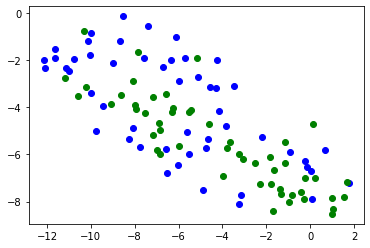

In [5]:
tsne = TSNE(n_components=2)#tsne降维
#pca = PCA(n_components=10)
tsne_df=tsne.fit_transform(df.reshape(df.shape[0],-1))
#pca_df=pca.fit_transform(df.reshape(df.shape[0],-1))
#print(tsne_df[:374,0])
plt.scatter(tsne_df[:51,0],tsne_df[:51,1],c='b')
#plt.scatter(tsne_df[1][0],tsne_df[1][1],c='b')
#plt.scatter(tsne_df[2][0],tsne_df[2][1],c='b')
#plt.scatter(tsne_df[3][0],tsne_df[3][1],c='b')
#plt.scatter(tsne_df[4][0],tsne_df[4][1],c='b')
plt.scatter(tsne_df[51:,0],tsne_df[51:,1],c='g')
plt.show()

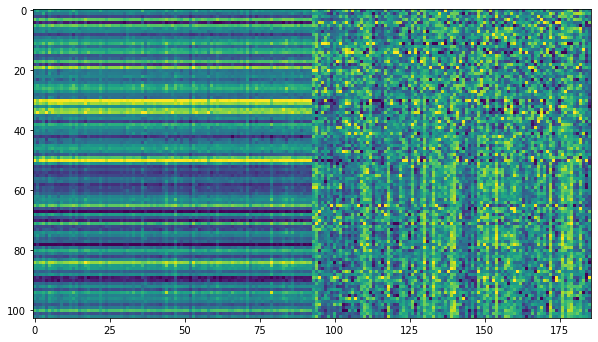

In [6]:
fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
plt.imshow(min_max_scaler.fit_transform(df))
plt.show()

In [7]:
x_train,x_test,y_train,y_test = train_test_split(df , label, test_size = 0.1)  

In [8]:
def model_train_test(this_train_x,this_train_y,this_test_x,this_test_y): 
    acc_total_train = 0
    acc_total_test = 0
    model = SVC(C=4,kernel='linear', degree=1)
    ros=RandomOverSampler(random_state=0) #采用随机过采样（上采样）
    #smote_nc = SMOTENC(categorical_features=[0,2], random_state=0)
    #this_train_x,this_train_y=ros.fit_resample(this_train_x,this_train_y)
    #this_train_x,this_train_y=SMOTE().fit_resample(this_train_x,this_train_y)
    #this_train_x,this_train_y=smote_nc().fit_resample(this_train_x,this_train_y)
    #this_train_x,this_train_y=ADASYN().fit_resample(this_train_x,this_train_y)
    #model = RandomForestClassifier(random_state=0,n_estimators=100,max_features=100)
    #model = KNeighborsClassifier(n_neighbors=2, weights='distance')
    #rus=RandomUnderSampler(random_state=0,replacement=True) #采用随机欠采样（下采样）
    #fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
    #plt.imshow(min_max_scaler.fit_transform(this_train_x))
    #plt.show()
    #this_train_x,this_train_y=ros.fit_resample(this_train_x,this_train_y)
    #fig = plt.figure(figsize=(10,10), facecolor='w', edgecolor='k')
    #plt.imshow(min_max_scaler.fit_transform(this_train_x))
    #plt.show()
    model.fit(this_train_x, this_train_y)

    pred = model.predict(this_train_x)
    acc = accuracy_score(this_train_y, pred)
    
    fpr_train,tpr_train,threshold_train = roc_curve(this_train_y, pred) 
    roc_auc_train = auc(fpr_train,tpr_train)
    acc_total_train += acc
    pred = model.predict(this_test_x)
    acc = accuracy_score(this_test_y, pred)
    #print(this_test_y)
    #print(pred)
    #this_confusion_matrix=confusion_matrix[this_test_y, pred]
    fpr,tpr,threshold = roc_curve(this_test_y, pred) 
    roc_auc = auc(fpr,tpr)
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='test ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr_train, tpr_train, color='red',
         lw=lw, label='train ROC curve (area = %0.2f)' % roc_auc_train) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    if(len(set(this_test_y))!=1):
        roc=roc_auc_score(this_test_y, pred)
        sensitivity=confusion_matrix(this_test_y, pred)[0][0]/(confusion_matrix(this_test_y, pred)[0][0]+confusion_matrix(this_test_y, pred)[0][1])
        specificity=confusion_matrix(this_test_y, pred)[1][1]/(confusion_matrix(this_test_y, pred)[1][1]+confusion_matrix(this_test_y, pred)[1][0])
    else:
        roc=0
        sensitivity=0
        specificity=0
    acc_total_test += acc
    print('\n 训练集',acc_total_train, '测试集', acc_total_test)
    return acc_total_test,acc_total_train,roc,sensitivity,specificity#,this_confusion_matrix

In [9]:
def kfold_train_test(n):
    from sklearn.model_selection import KFold
    accuracy = list()   
    train_accuracy = [] 
    roc_all=[]
    sensitivity_all=[]
    specificity_all=[]
    confusion_matrix_all=np.zeros((2,2))
    k =10    #10折交叉验证重复k次
    for i in range(k):
        kfold = KFold(n_splits=n,shuffle=True)
        for train_index, test_index in kfold.split(df, label):
            # train_index 就是分类的训练集的下标，test_index 就是分配的验证集的下标
            this_train_x, this_train_y = df[train_index], label[train_index]  # 本组训练集
            this_test_x, this_test_y = df[test_index], label[test_index]  # 本组验证集
            # 训练本组的数据，并计算准确率
            acc,train_acc,roc,sensitivity,specificity=model_train_test(this_train_x,this_train_y,this_test_x,this_test_y)
            #confusion_matrix_all+=confusion_matrix
            #print(confusion_matrix.shape)
            accuracy.append(acc)
            train_accuracy.append(train_acc)
            print('roc:',roc)
            print('sensitivity:',sensitivity)
            print('specificity:',specificity)
            roc_all.append(roc)
            sensitivity_all.append(sensitivity)
            specificity_all.append(specificity)
            #print(accuracy)  # 得到预测结果区间[0,1]
    roc_all=np.array(roc_all)
    roc_all=roc_all[np.nonzero(roc_all)]
    sensitivity_all=np.array(sensitivity_all)
    sensitivity_all=sensitivity_all[np.nonzero(sensitivity_all)]
    specificity_all=np.array(specificity_all)
    specificity_all=specificity_all[np.nonzero(specificity_all)]
    print('average test accuracy:',np.array(accuracy).sum()/(k*n))
    print('average train accuracy:',np.array(train_accuracy).sum()/(k*n))
    print('average roc:',np.array(roc_all).sum()/np.array(roc_all).shape[0])
    print('average sensitivity:',np.array(sensitivity_all).sum()/np.array(sensitivity_all).shape[0])
    print('average specificity:',np.array(specificity_all).sum()/np.array(specificity_all).shape[0])
    plt.plot(np.array(accuracy))
    plt.plot(np.array(train_accuracy))

<Figure size 432x288 with 0 Axes>

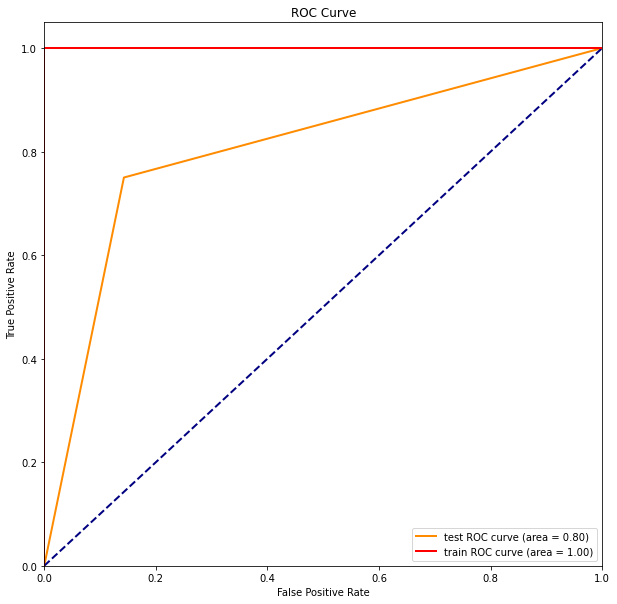


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8035714285714286
sensitivity: 0.8571428571428571
specificity: 0.75


<Figure size 432x288 with 0 Axes>

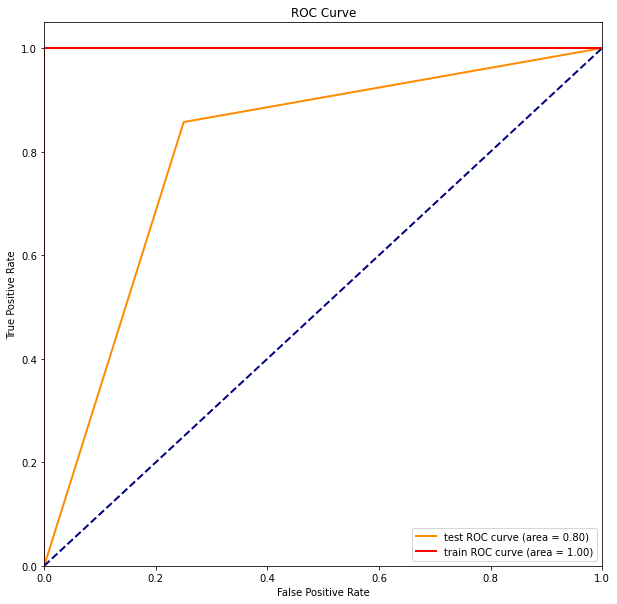


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8035714285714285
sensitivity: 0.75
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

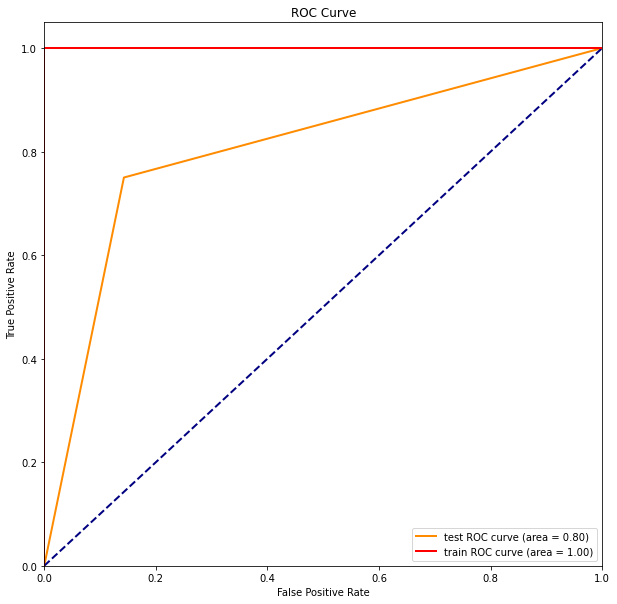


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8035714285714286
sensitivity: 0.8571428571428571
specificity: 0.75


<Figure size 432x288 with 0 Axes>

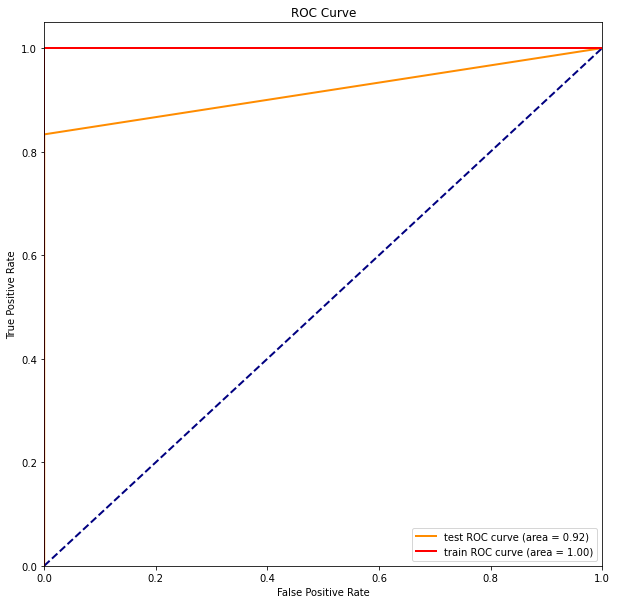


 训练集 1.0 测试集 0.9
roc: 0.9166666666666667
sensitivity: 1.0
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

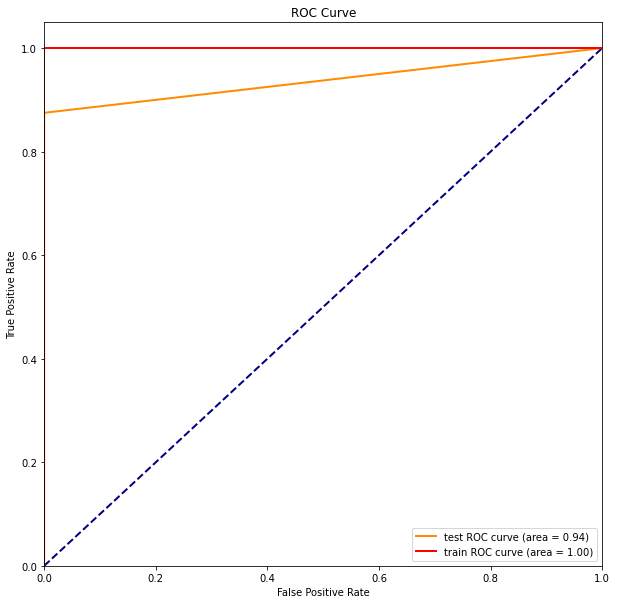


 训练集 1.0 测试集 0.9
roc: 0.9375
sensitivity: 1.0
specificity: 0.875


<Figure size 432x288 with 0 Axes>

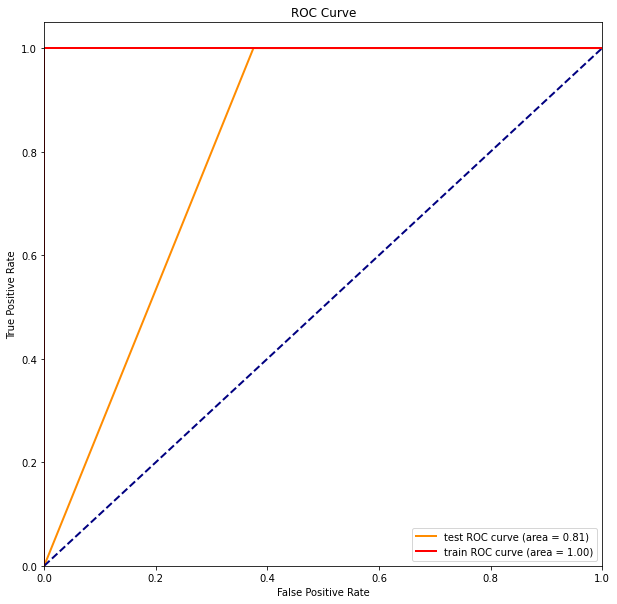


 训练集 1.0 测试集 0.7
roc: 0.8125
sensitivity: 0.625
specificity: 1.0


<Figure size 432x288 with 0 Axes>

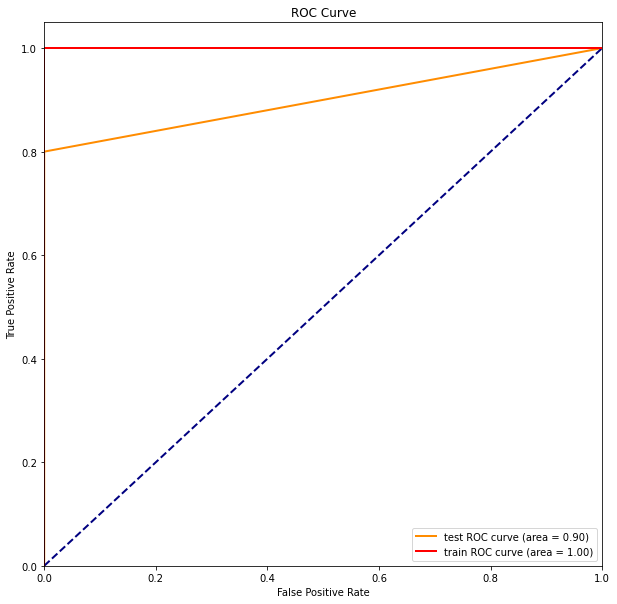


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 1.0
specificity: 0.8


<Figure size 432x288 with 0 Axes>

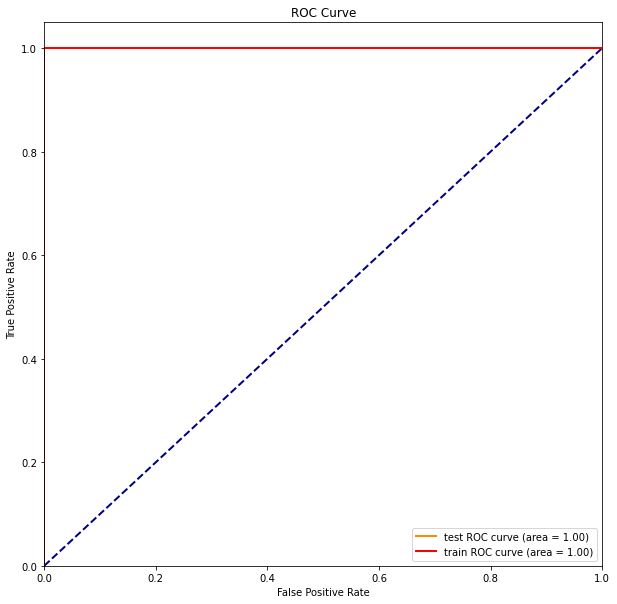


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

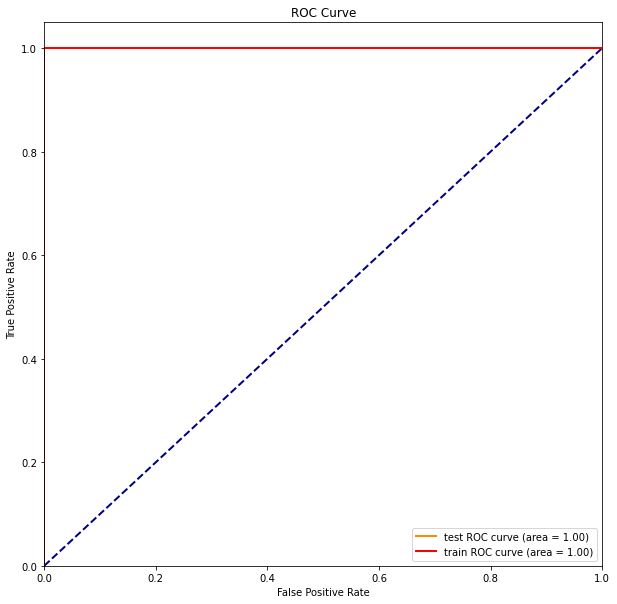


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

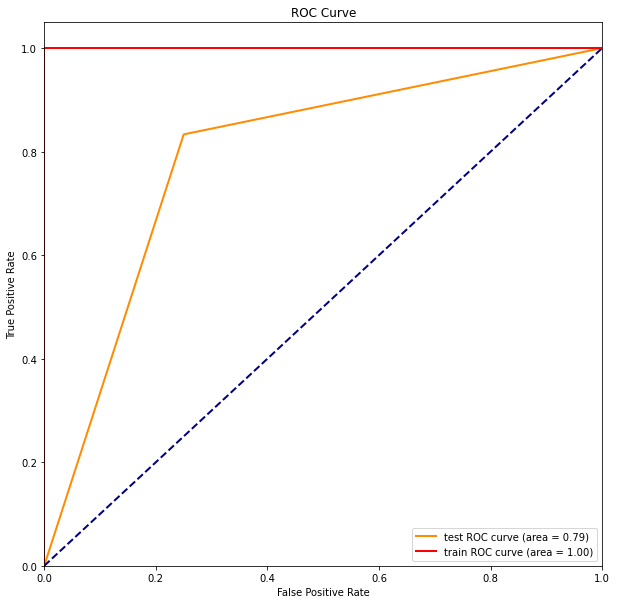


 训练集 1.0 测试集 0.8
roc: 0.7916666666666666
sensitivity: 0.75
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

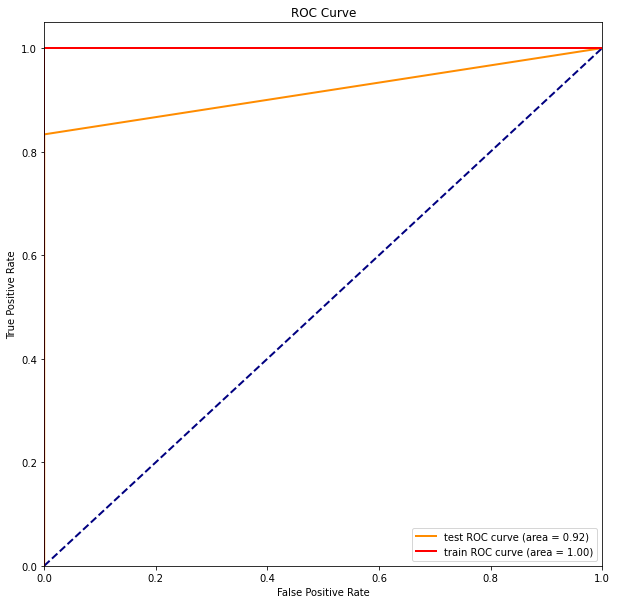


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9166666666666667
sensitivity: 1.0
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

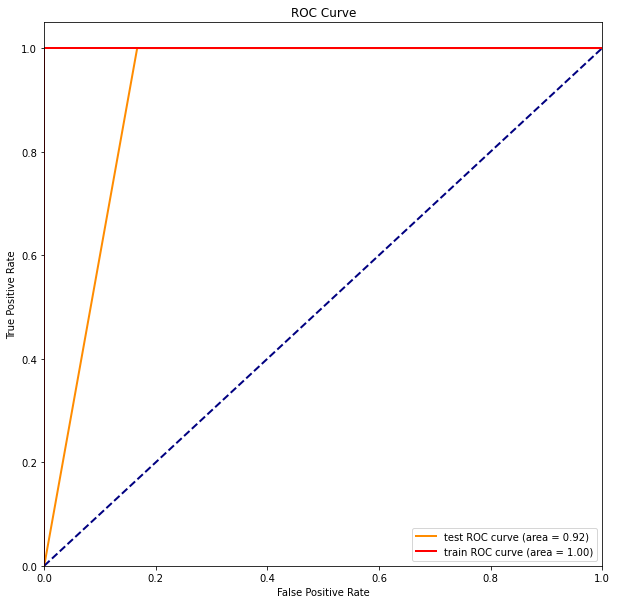


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9166666666666667
sensitivity: 0.8333333333333334
specificity: 1.0


<Figure size 432x288 with 0 Axes>

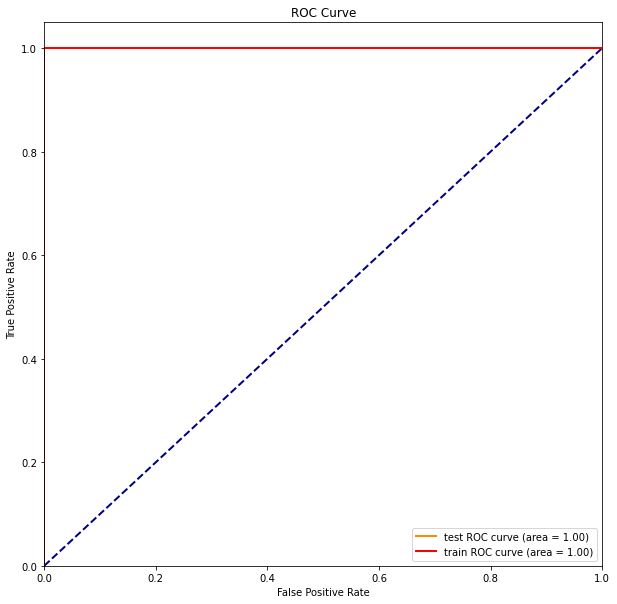


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

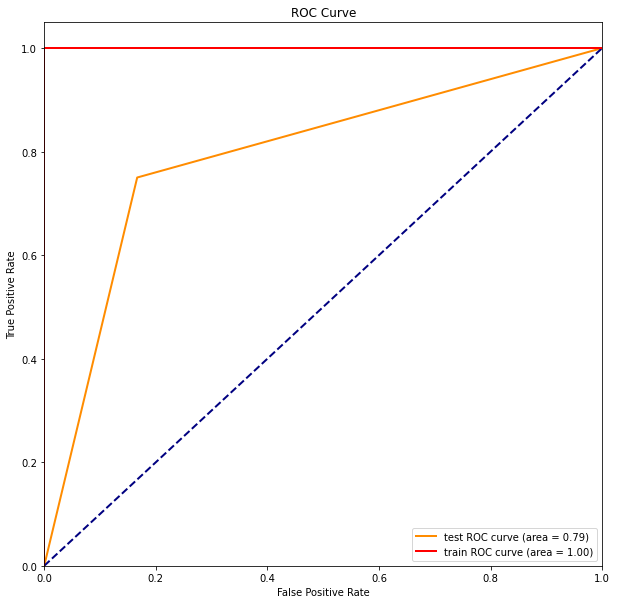


 训练集 1.0 测试集 0.8
roc: 0.7916666666666667
sensitivity: 0.8333333333333334
specificity: 0.75


<Figure size 432x288 with 0 Axes>

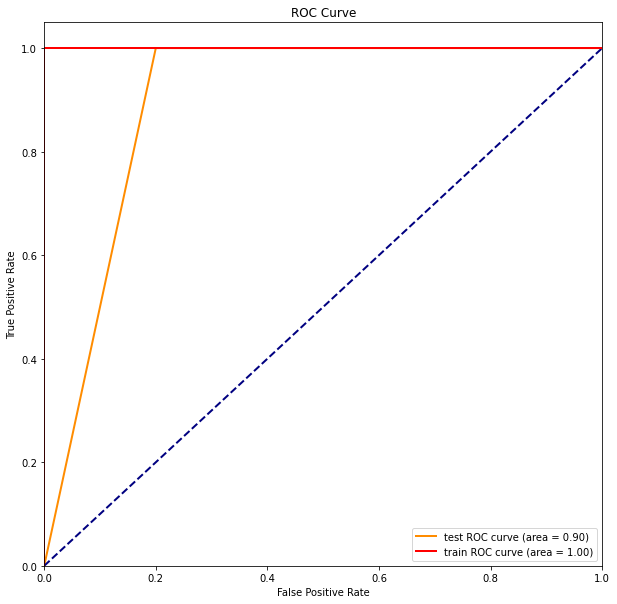


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 0.8
specificity: 1.0


<Figure size 432x288 with 0 Axes>

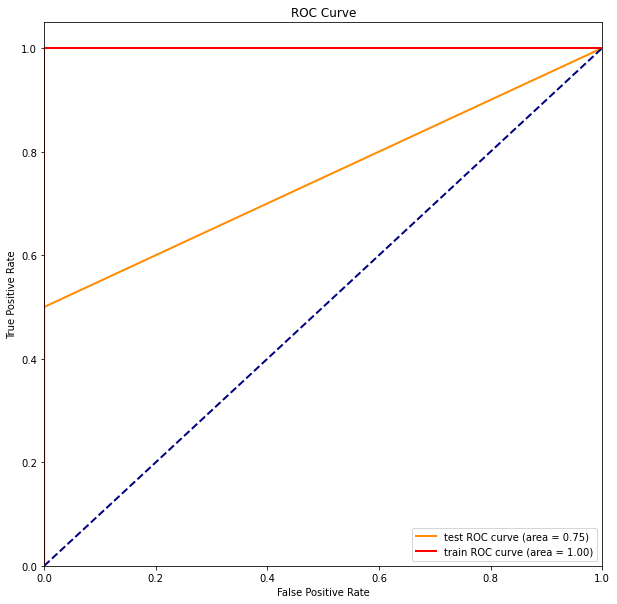


 训练集 1.0 测试集 0.8
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

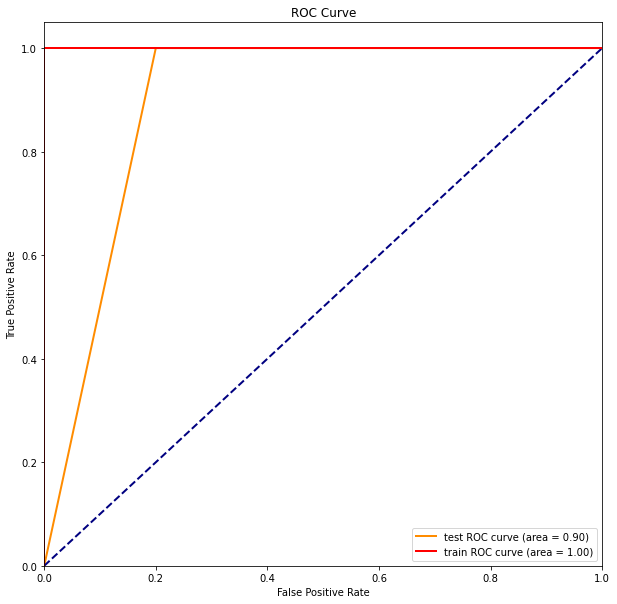


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 0.8
specificity: 1.0


<Figure size 432x288 with 0 Axes>

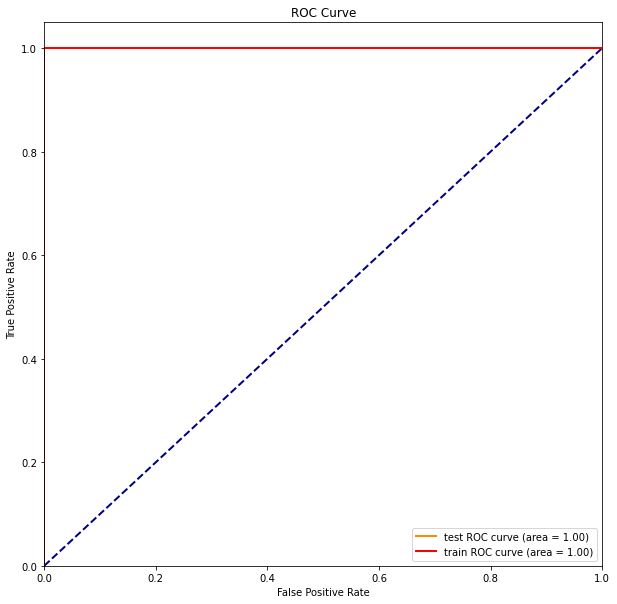


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

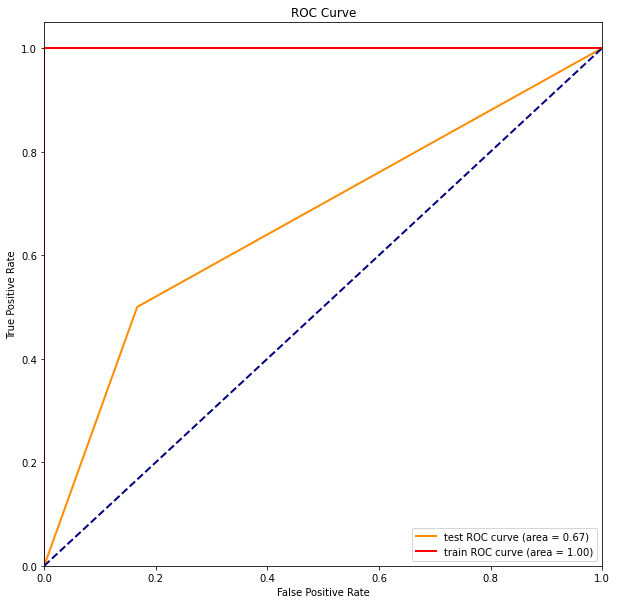


 训练集 1.0 测试集 0.7
roc: 0.6666666666666666
sensitivity: 0.8333333333333334
specificity: 0.5


<Figure size 432x288 with 0 Axes>

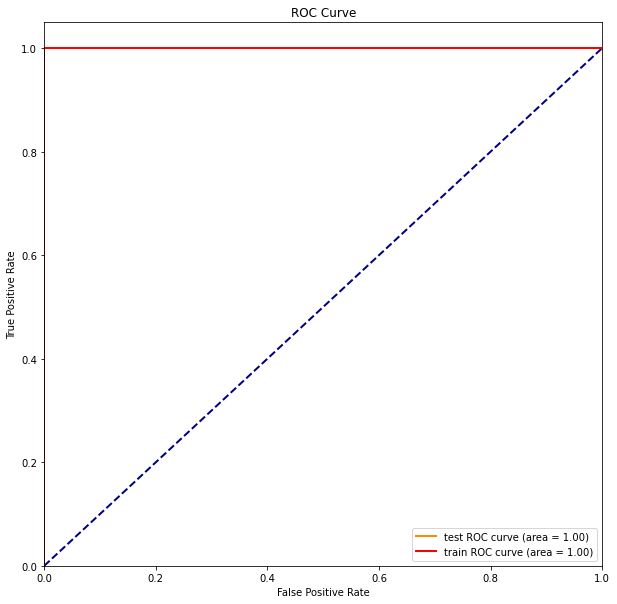


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

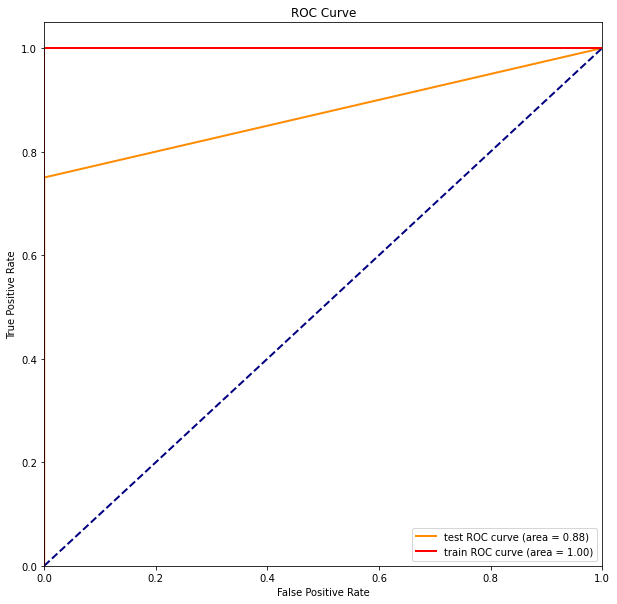


 训练集 1.0 测试集 0.9090909090909091
roc: 0.875
sensitivity: 1.0
specificity: 0.75


<Figure size 432x288 with 0 Axes>

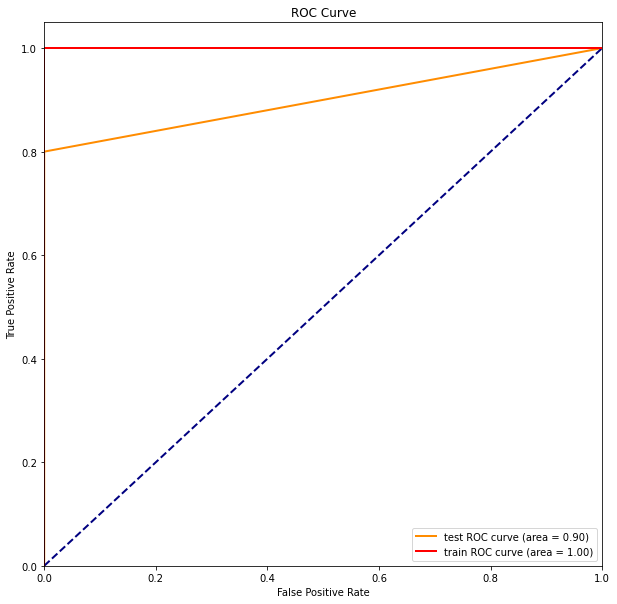


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9
sensitivity: 1.0
specificity: 0.8


<Figure size 432x288 with 0 Axes>

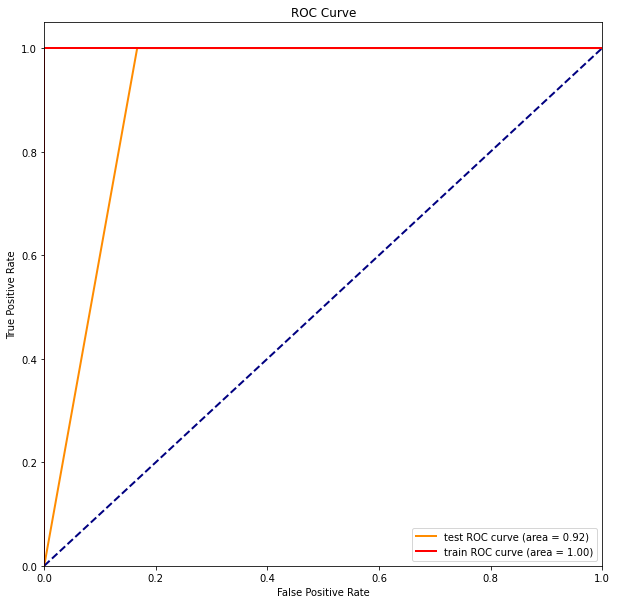


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9166666666666667
sensitivity: 0.8333333333333334
specificity: 1.0


<Figure size 432x288 with 0 Axes>

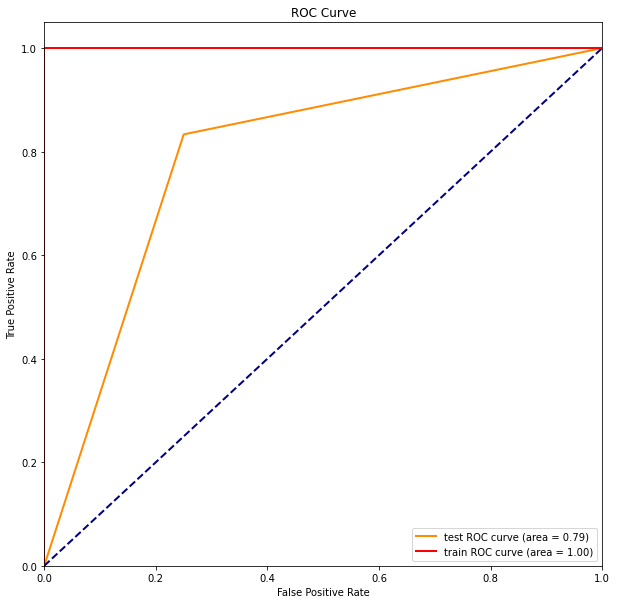


 训练集 1.0 测试集 0.8
roc: 0.7916666666666666
sensitivity: 0.75
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

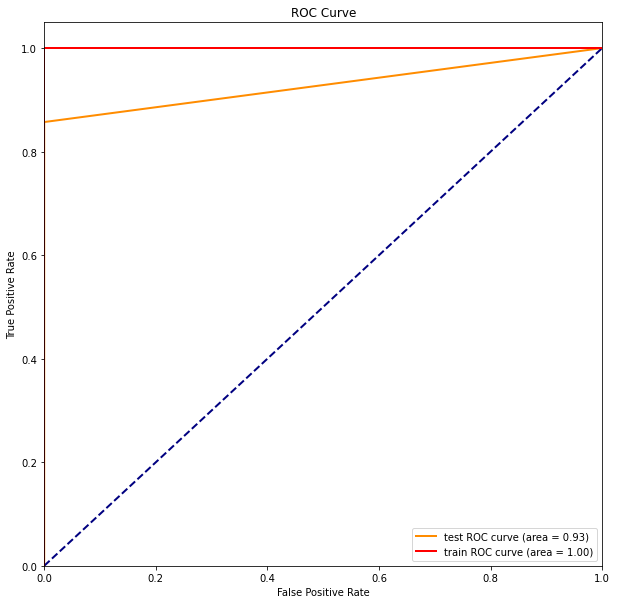


 训练集 1.0 测试集 0.9
roc: 0.9285714285714286
sensitivity: 1.0
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

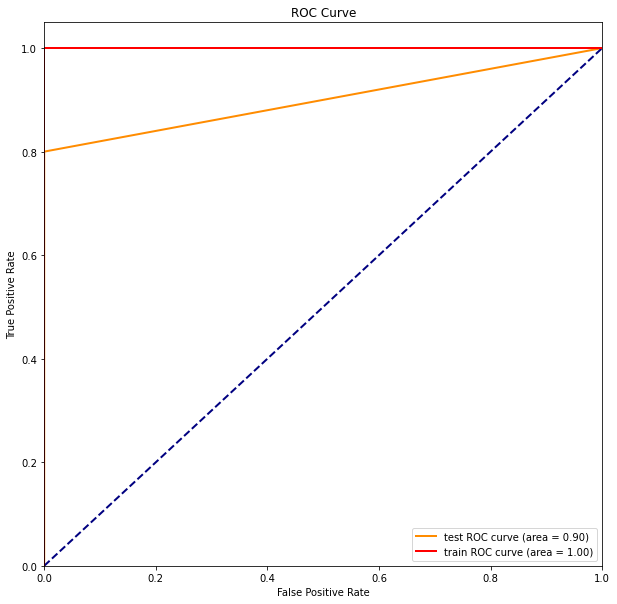


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 1.0
specificity: 0.8


<Figure size 432x288 with 0 Axes>

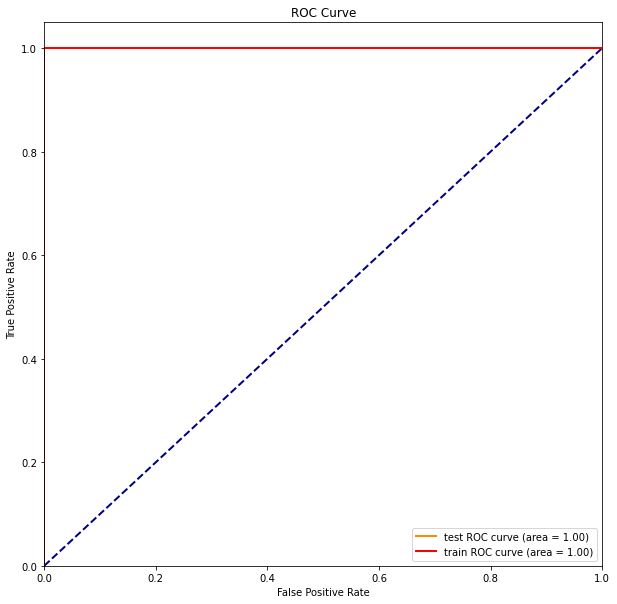


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

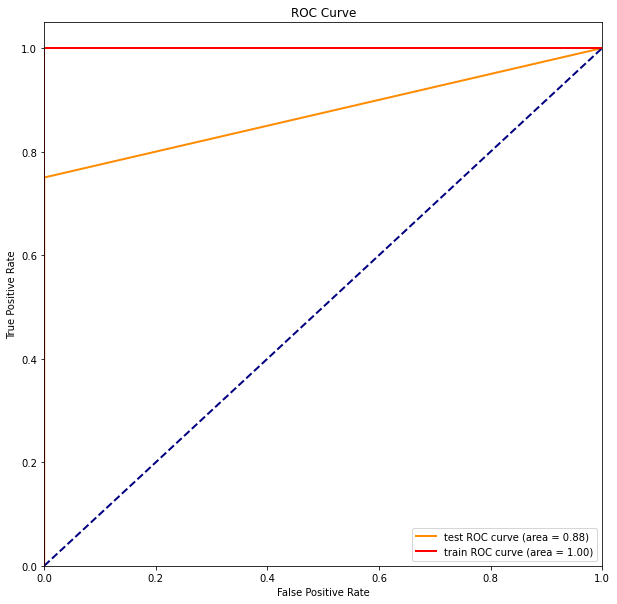


 训练集 1.0 测试集 0.9
roc: 0.875
sensitivity: 1.0
specificity: 0.75


<Figure size 432x288 with 0 Axes>

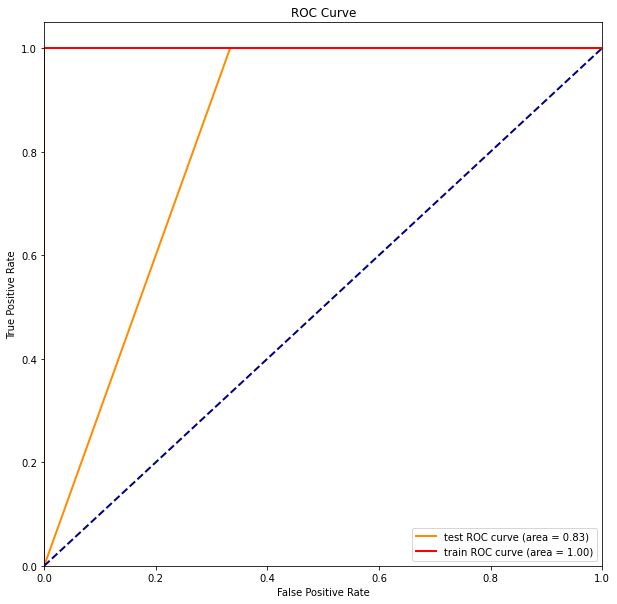


 训练集 1.0 测试集 0.8
roc: 0.8333333333333334
sensitivity: 0.6666666666666666
specificity: 1.0


<Figure size 432x288 with 0 Axes>

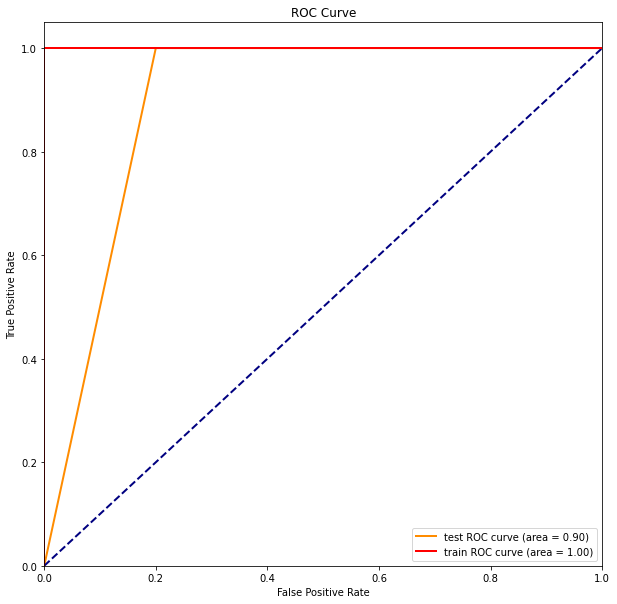


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 0.8
specificity: 1.0


<Figure size 432x288 with 0 Axes>

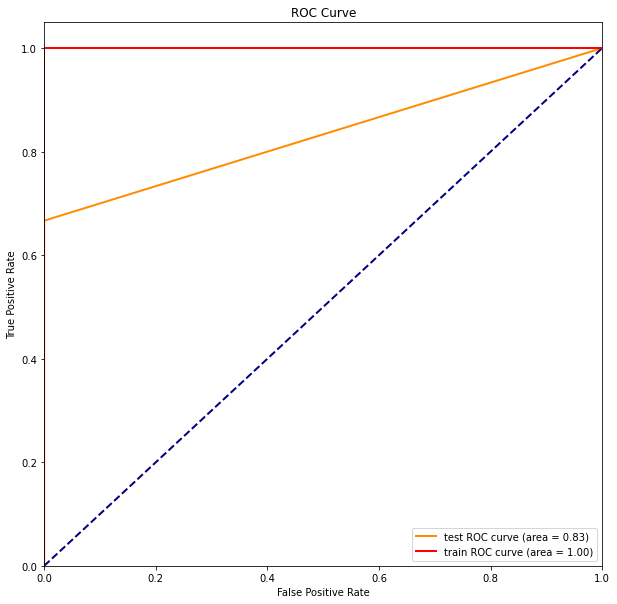


 训练集 1.0 测试集 0.9090909090909091
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

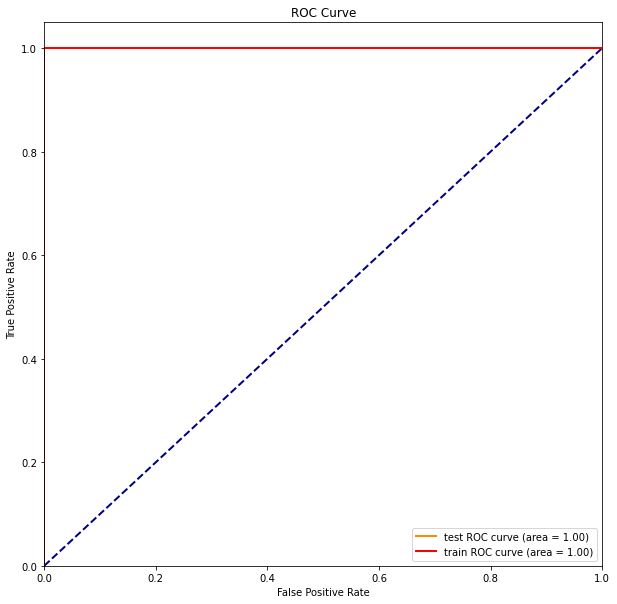


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

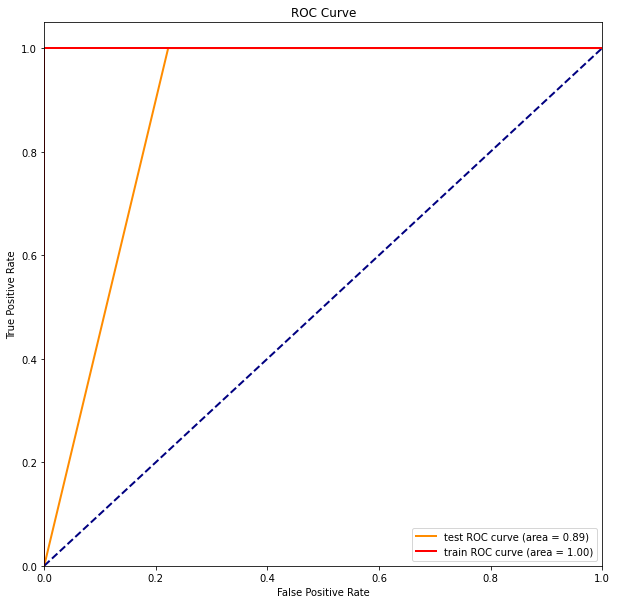


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8888888888888888
sensitivity: 0.7777777777777778
specificity: 1.0


<Figure size 432x288 with 0 Axes>

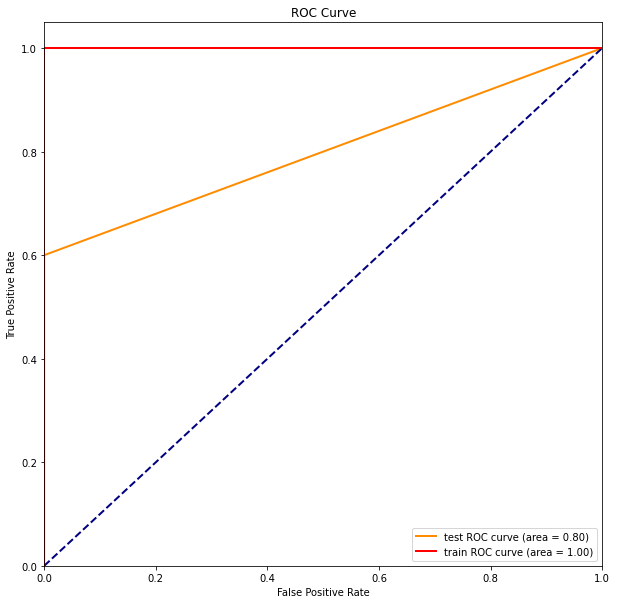


 训练集 1.0 测试集 0.8
roc: 0.8
sensitivity: 1.0
specificity: 0.6


<Figure size 432x288 with 0 Axes>

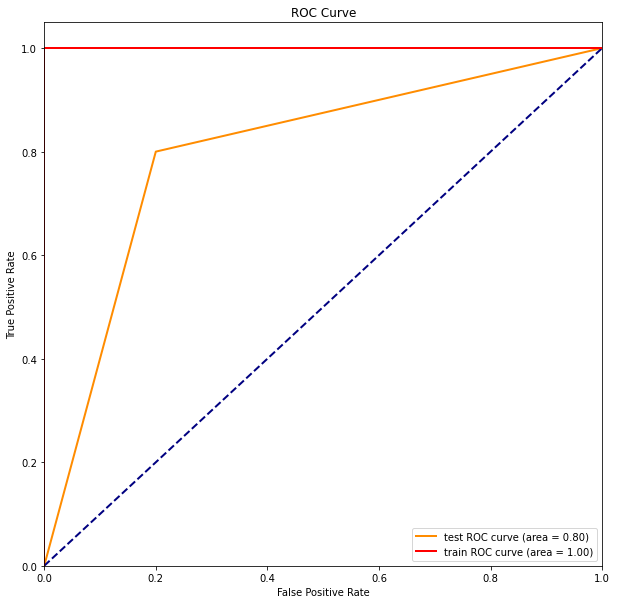


 训练集 1.0 测试集 0.8
roc: 0.8
sensitivity: 0.8
specificity: 0.8


<Figure size 432x288 with 0 Axes>

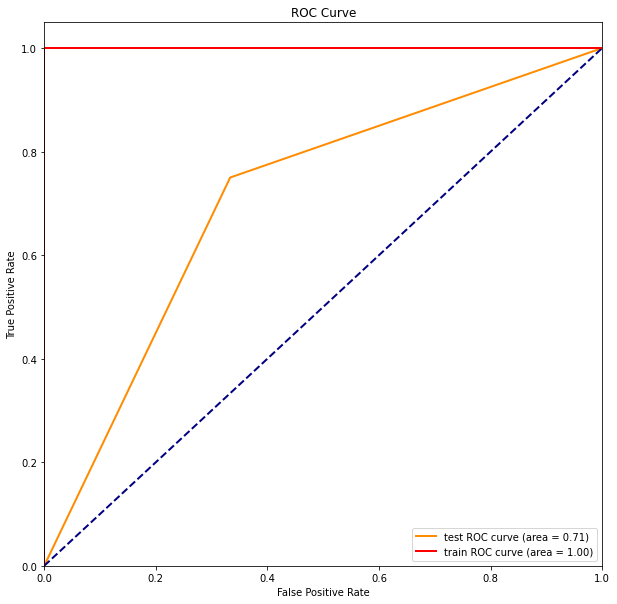


 训练集 1.0 测试集 0.7
roc: 0.7083333333333334
sensitivity: 0.6666666666666666
specificity: 0.75


<Figure size 432x288 with 0 Axes>

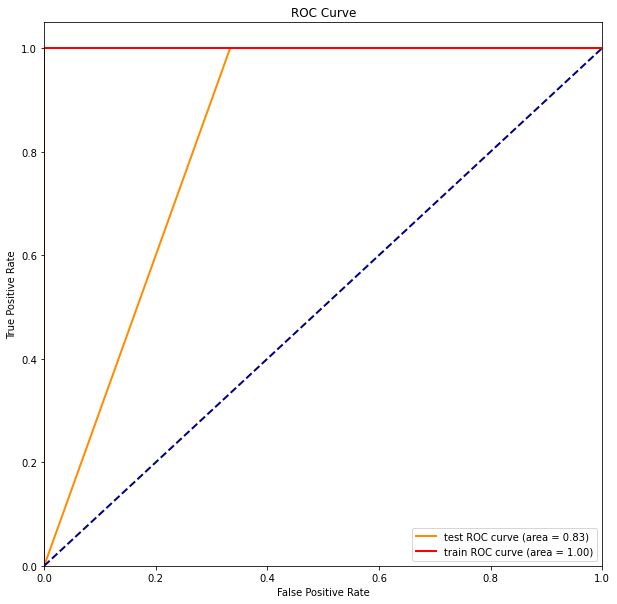


 训练集 1.0 测试集 0.9
roc: 0.8333333333333334
sensitivity: 0.6666666666666666
specificity: 1.0


<Figure size 432x288 with 0 Axes>

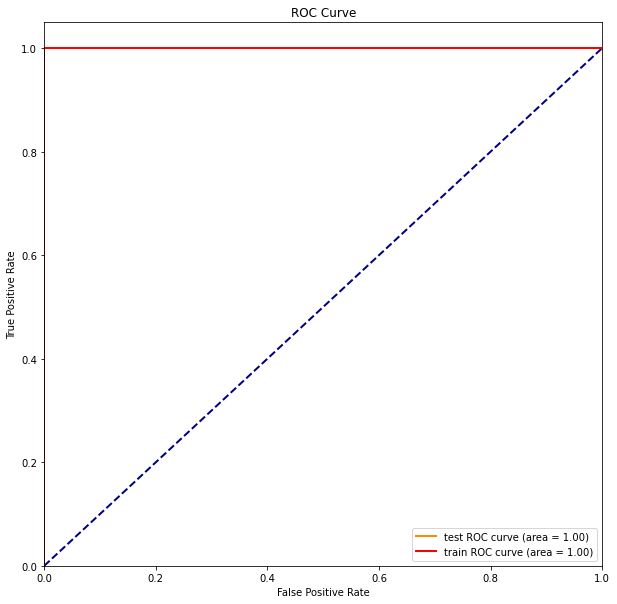


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

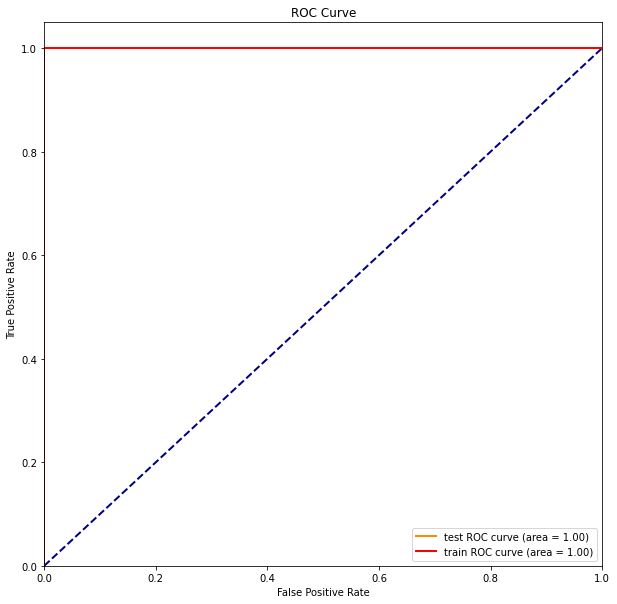


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

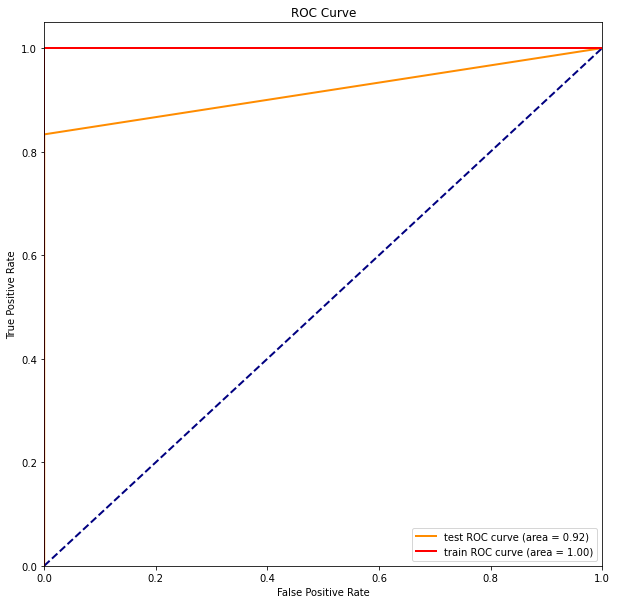


 训练集 1.0 测试集 0.9
roc: 0.9166666666666667
sensitivity: 1.0
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

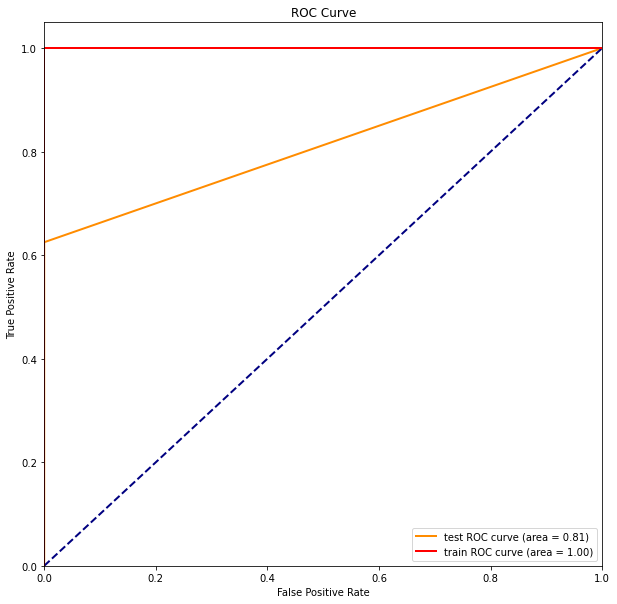


 训练集 1.0 测试集 0.7272727272727273
roc: 0.8125
sensitivity: 1.0
specificity: 0.625


<Figure size 432x288 with 0 Axes>

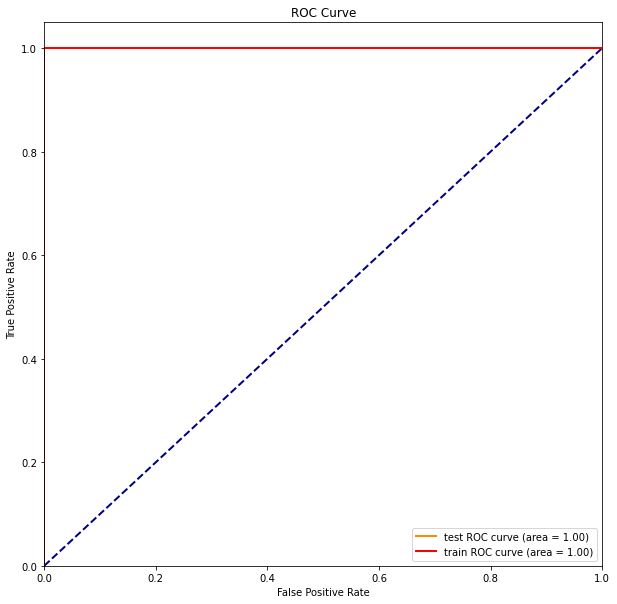


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

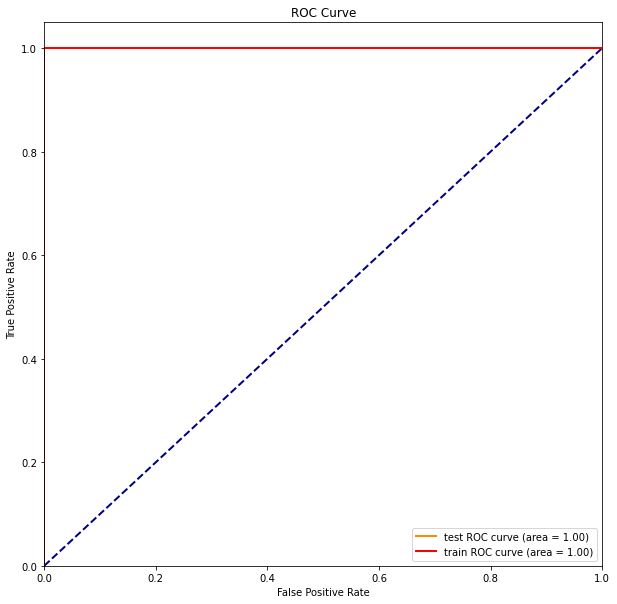


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

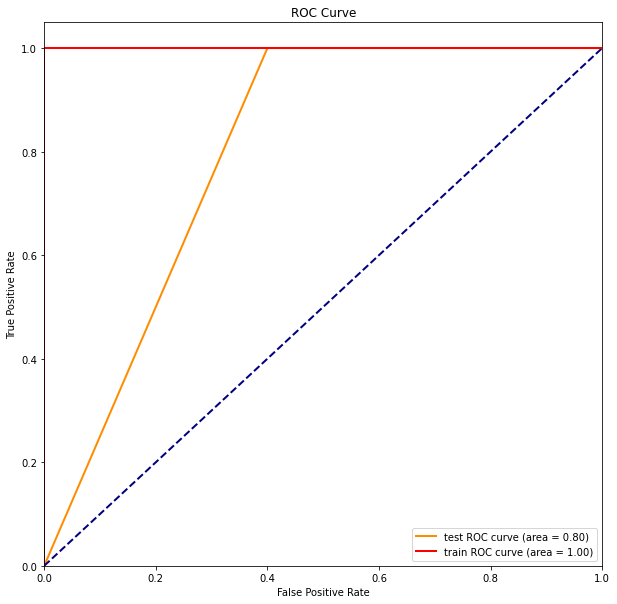


 训练集 1.0 测试集 0.8
roc: 0.8
sensitivity: 0.6
specificity: 1.0


<Figure size 432x288 with 0 Axes>

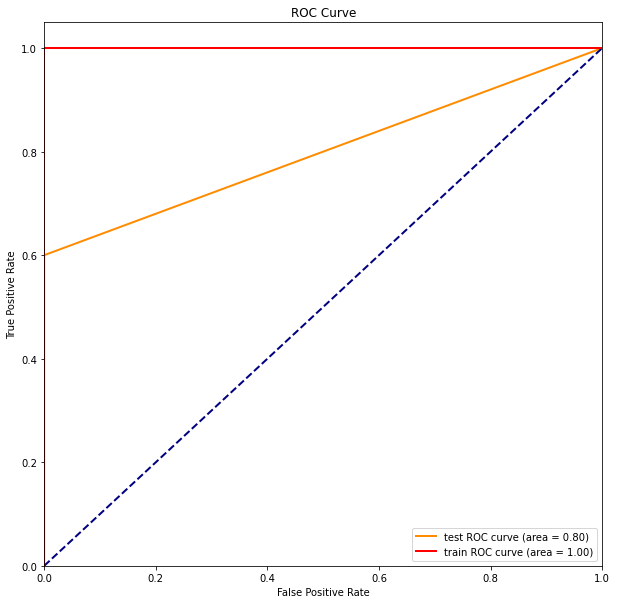


 训练集 1.0 测试集 0.8
roc: 0.8
sensitivity: 1.0
specificity: 0.6


<Figure size 432x288 with 0 Axes>

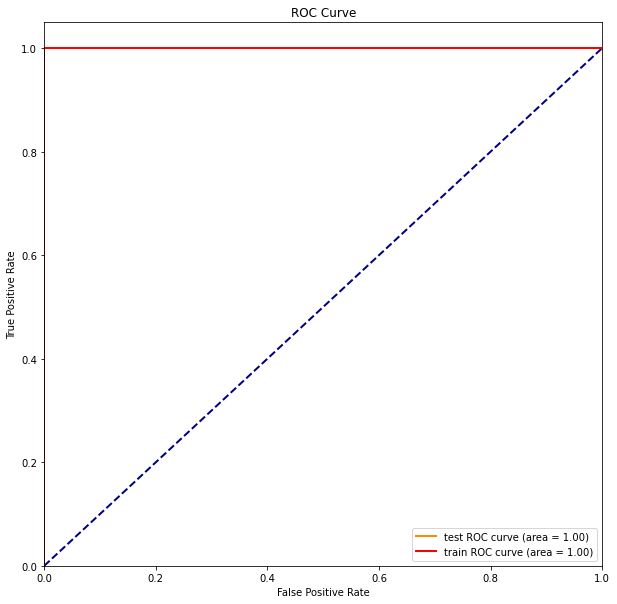


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

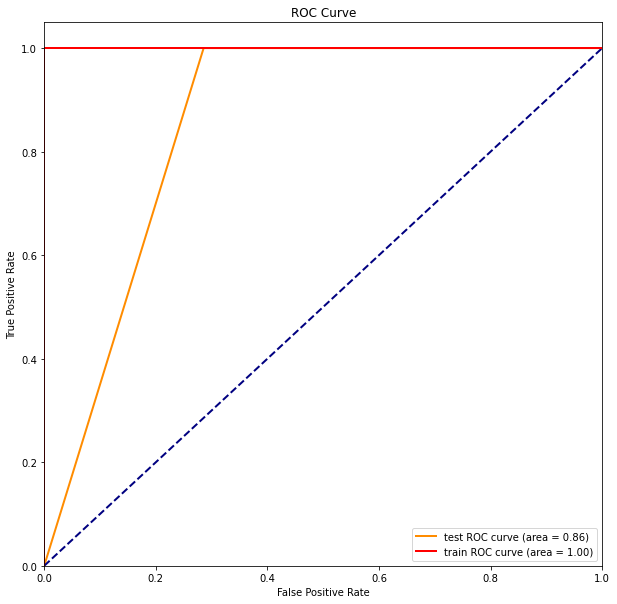


 训练集 1.0 测试集 0.8
roc: 0.8571428571428572
sensitivity: 0.7142857142857143
specificity: 1.0


<Figure size 432x288 with 0 Axes>

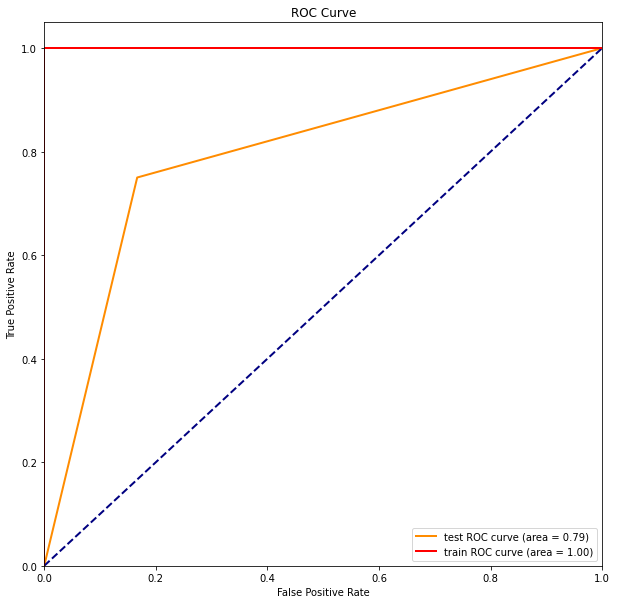


 训练集 1.0 测试集 0.8
roc: 0.7916666666666667
sensitivity: 0.8333333333333334
specificity: 0.75


<Figure size 432x288 with 0 Axes>

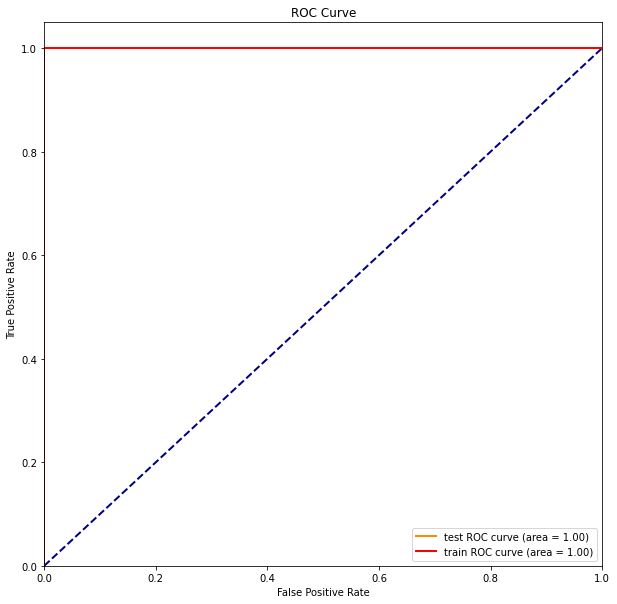


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

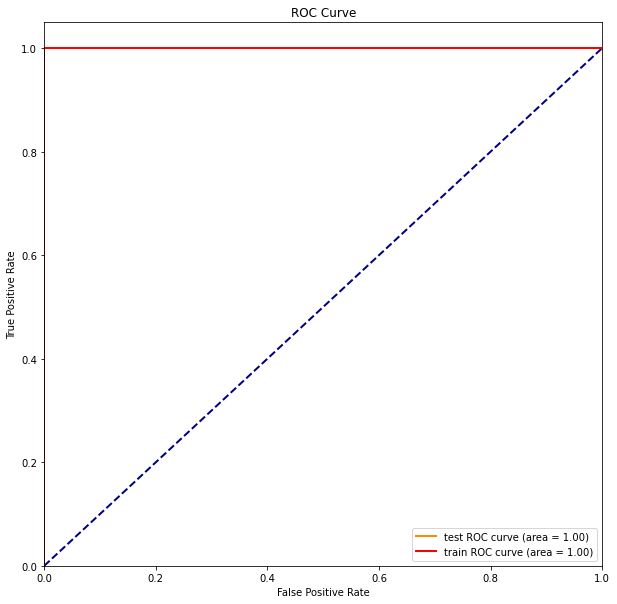


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

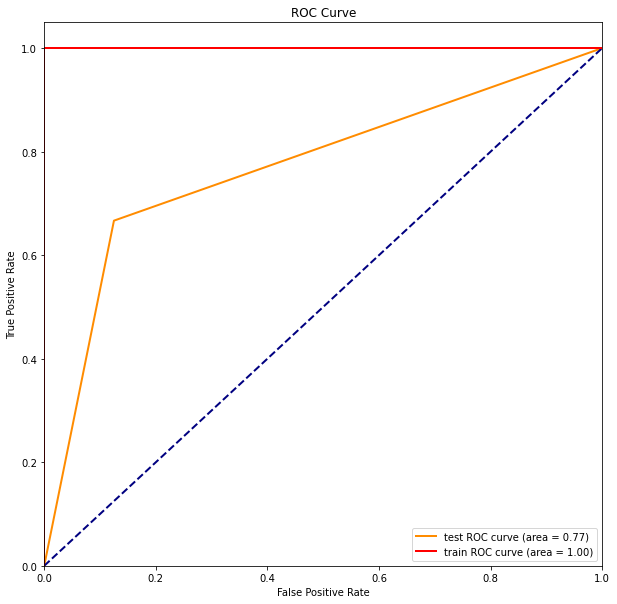


 训练集 1.0 测试集 0.8181818181818182
roc: 0.7708333333333333
sensitivity: 0.875
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

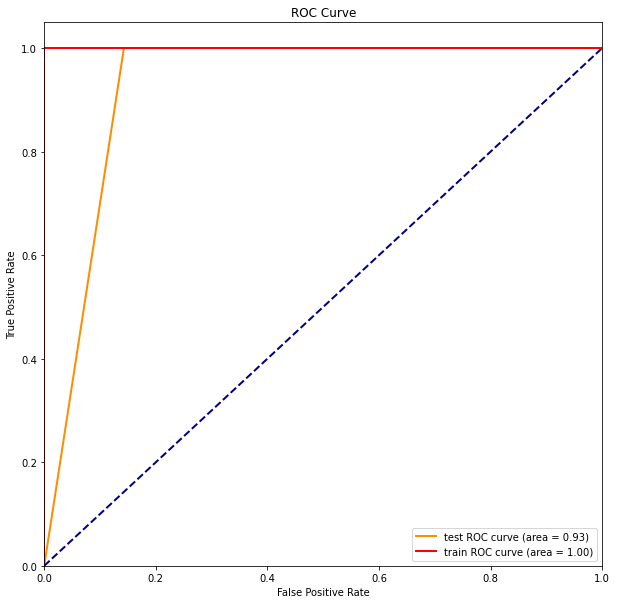


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

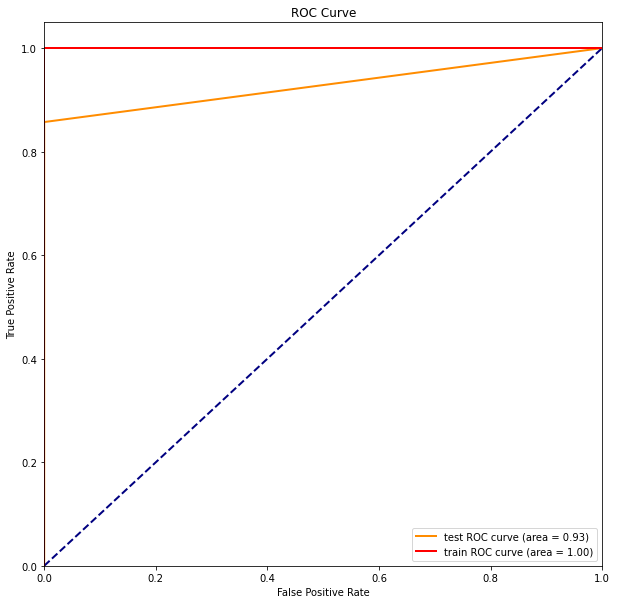


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9285714285714286
sensitivity: 1.0
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

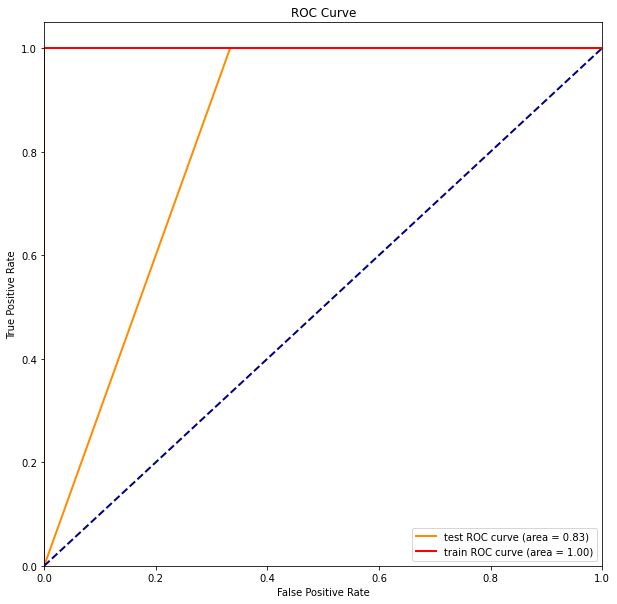


 训练集 1.0 测试集 0.8
roc: 0.8333333333333334
sensitivity: 0.6666666666666666
specificity: 1.0


<Figure size 432x288 with 0 Axes>

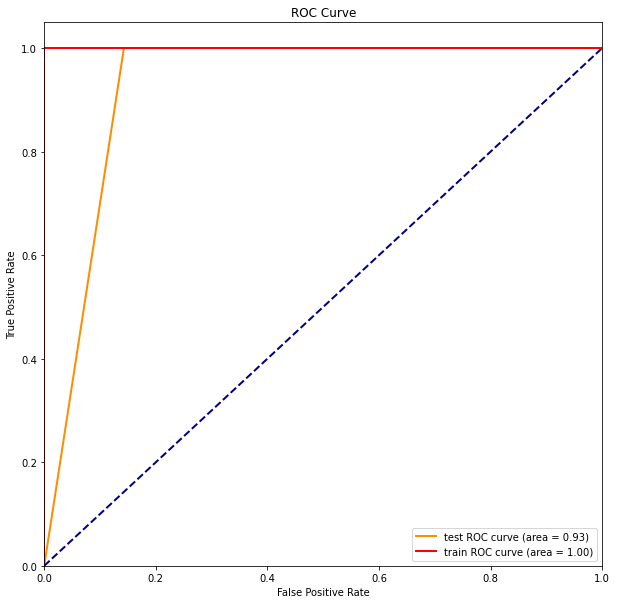


 训练集 1.0 测试集 0.9
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

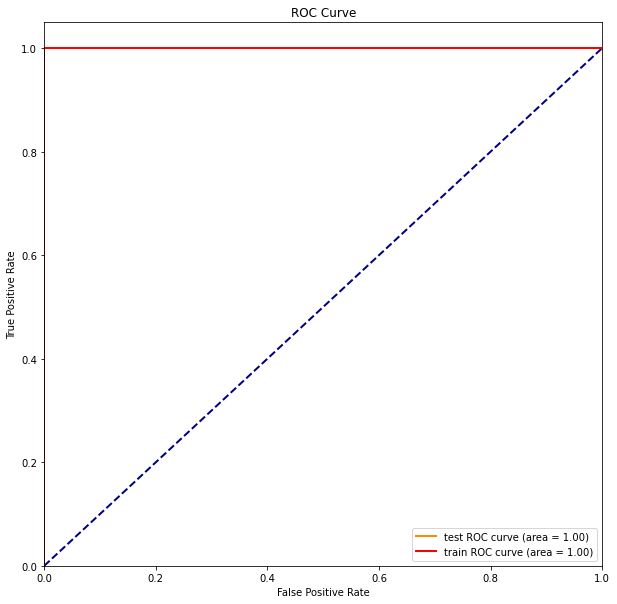


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

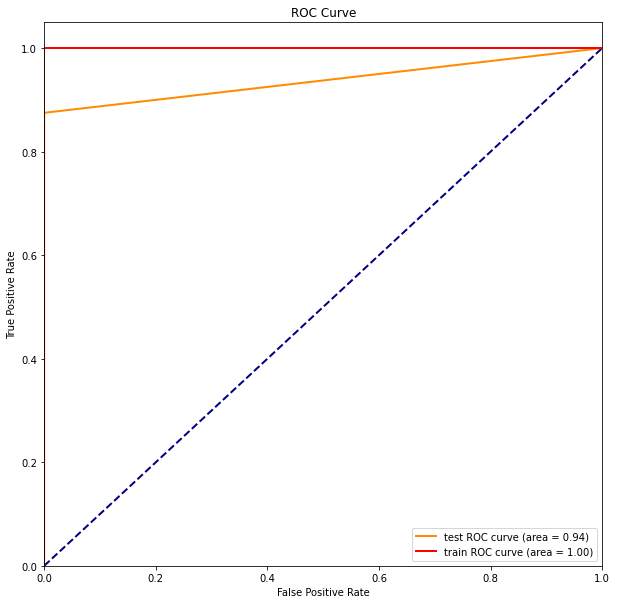


 训练集 1.0 测试集 0.9
roc: 0.9375
sensitivity: 1.0
specificity: 0.875


<Figure size 432x288 with 0 Axes>

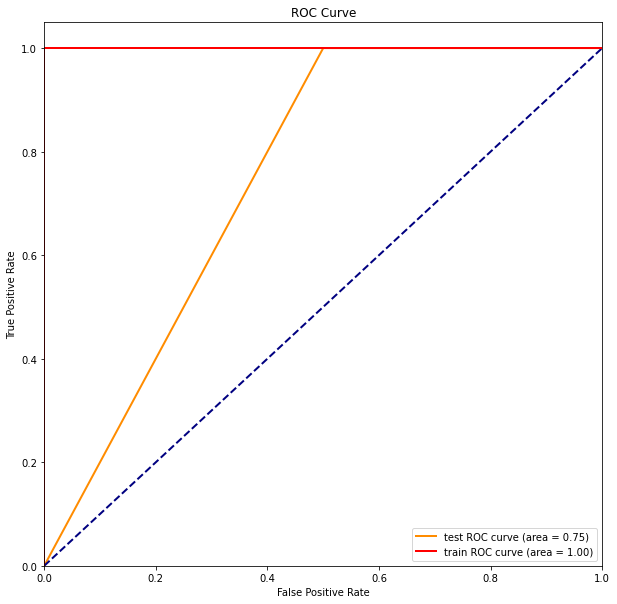


 训练集 1.0 测试集 0.7
roc: 0.75
sensitivity: 0.5
specificity: 1.0


<Figure size 432x288 with 0 Axes>

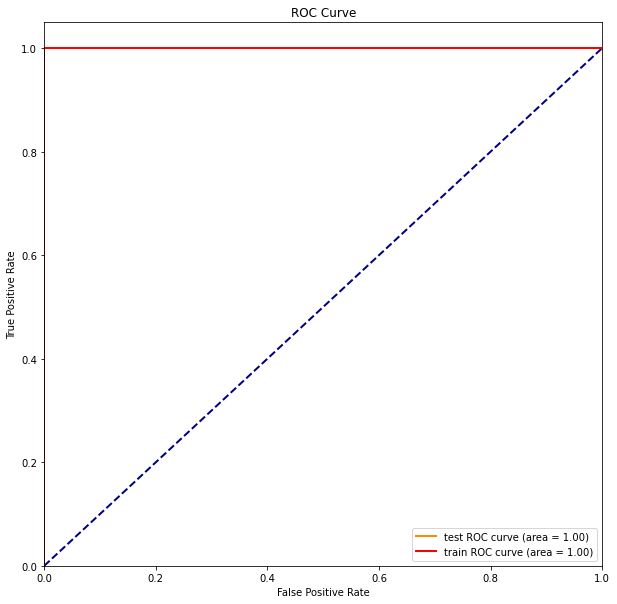


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

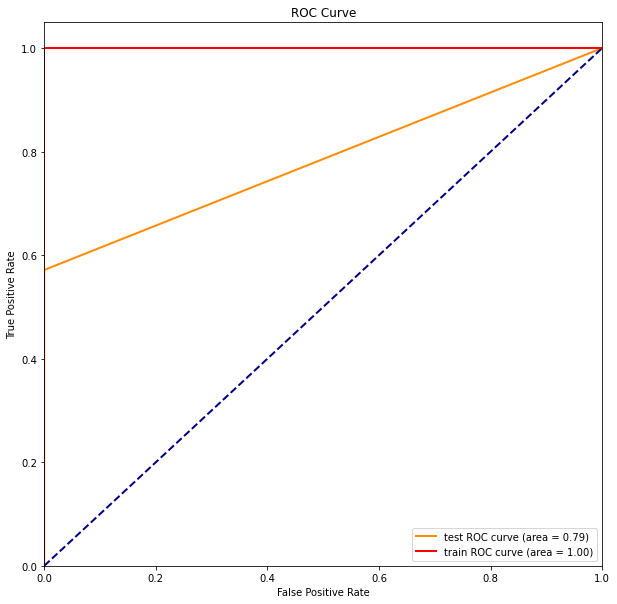


 训练集 1.0 测试集 0.7
roc: 0.7857142857142857
sensitivity: 1.0
specificity: 0.5714285714285714


<Figure size 432x288 with 0 Axes>

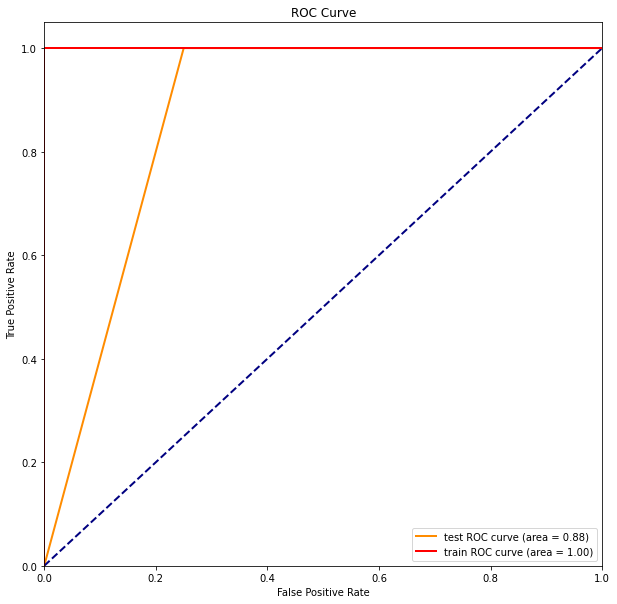


 训练集 1.0 测试集 0.9090909090909091
roc: 0.875
sensitivity: 0.75
specificity: 1.0


<Figure size 432x288 with 0 Axes>

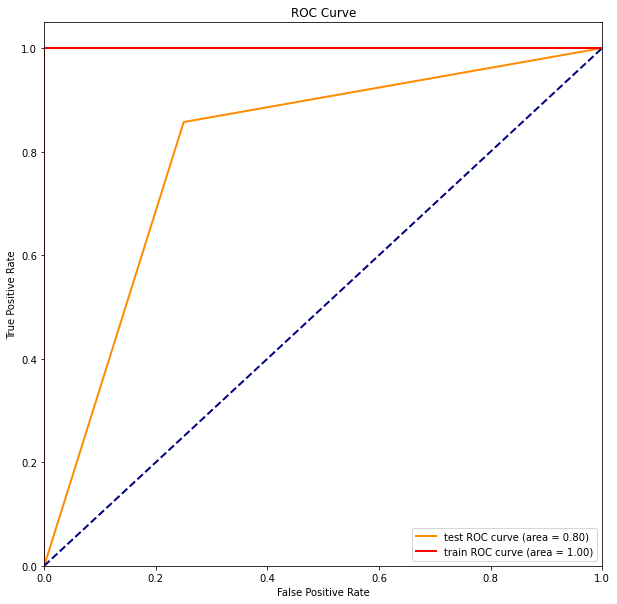


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8035714285714285
sensitivity: 0.75
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

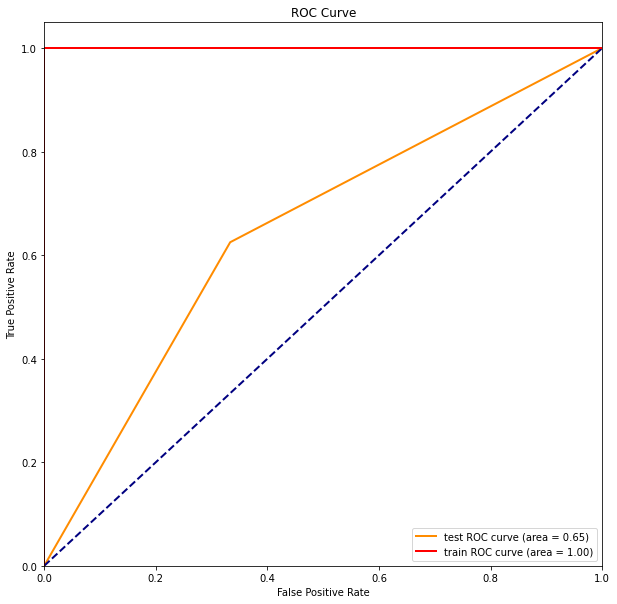


 训练集 1.0 测试集 0.6363636363636364
roc: 0.6458333333333334
sensitivity: 0.6666666666666666
specificity: 0.625


<Figure size 432x288 with 0 Axes>

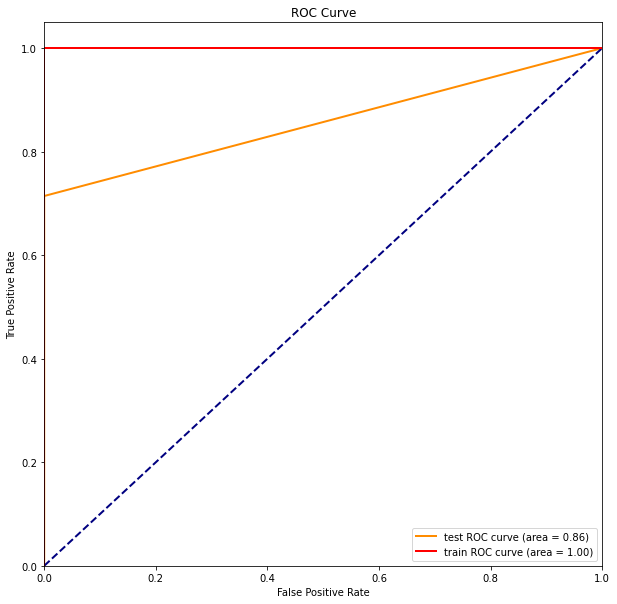


 训练集 1.0 测试集 0.8
roc: 0.8571428571428572
sensitivity: 1.0
specificity: 0.7142857142857143


<Figure size 432x288 with 0 Axes>

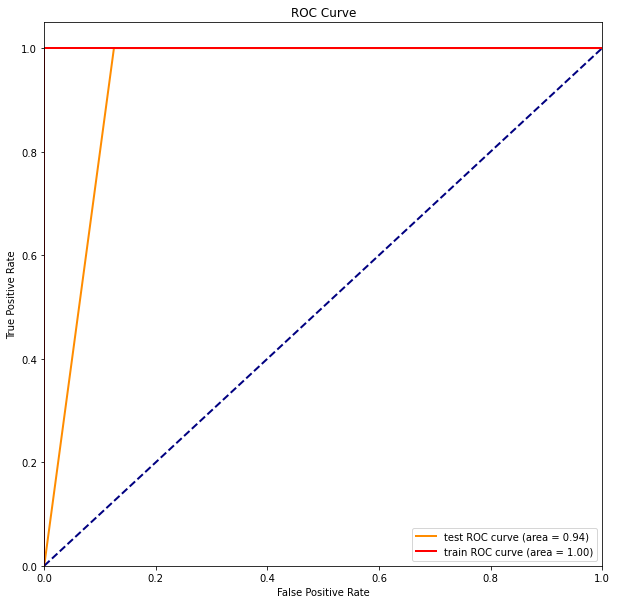


 训练集 1.0 测试集 0.9
roc: 0.9375
sensitivity: 0.875
specificity: 1.0


<Figure size 432x288 with 0 Axes>

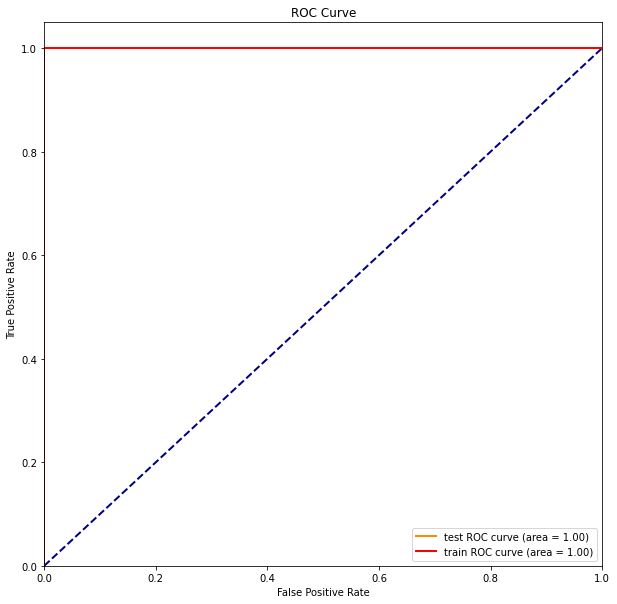


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

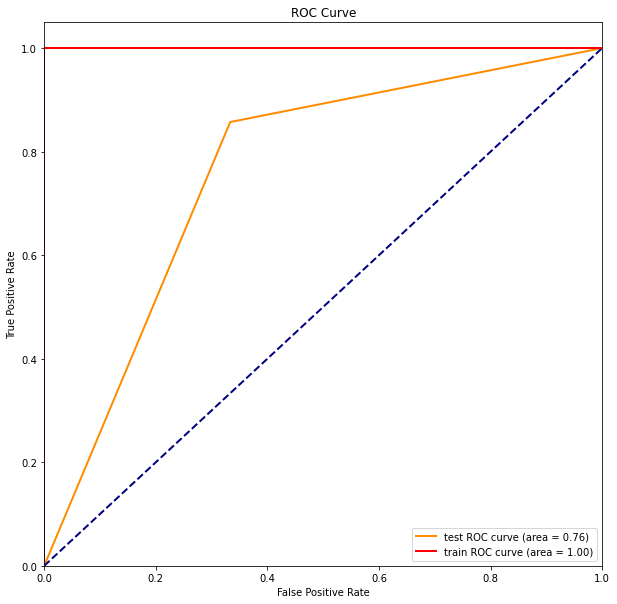


 训练集 1.0 测试集 0.8
roc: 0.7619047619047621
sensitivity: 0.6666666666666666
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

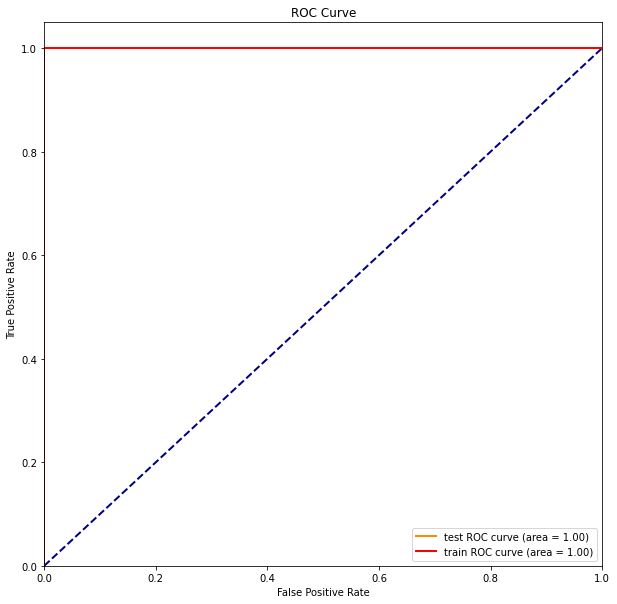


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

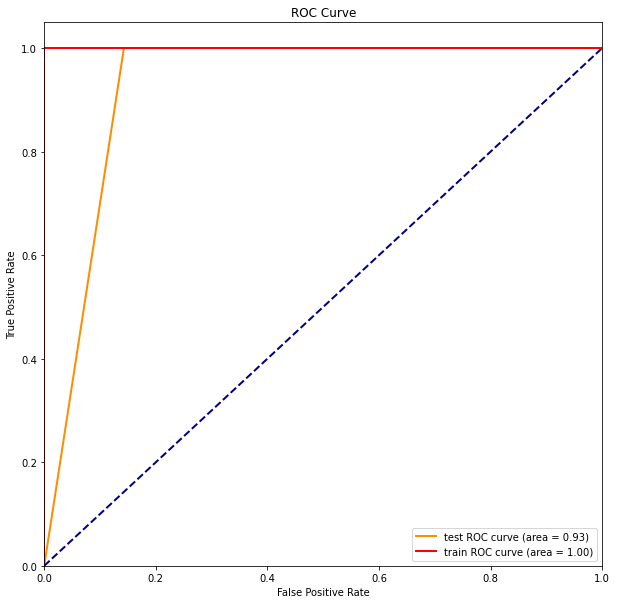


 训练集 1.0 测试集 0.9
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

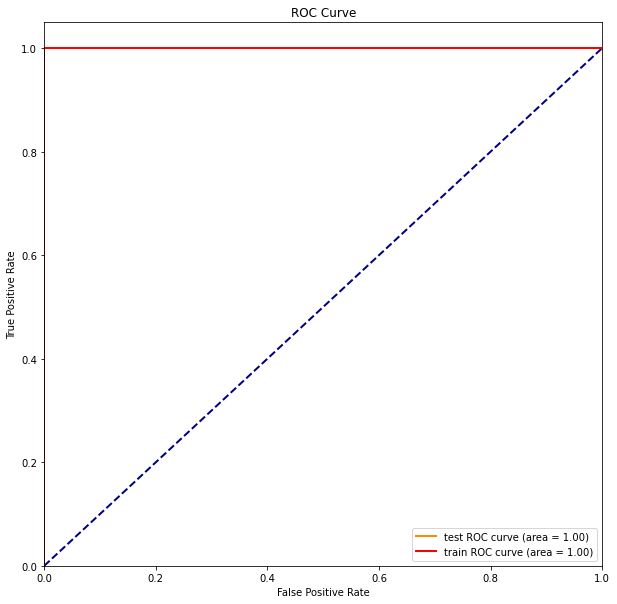


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

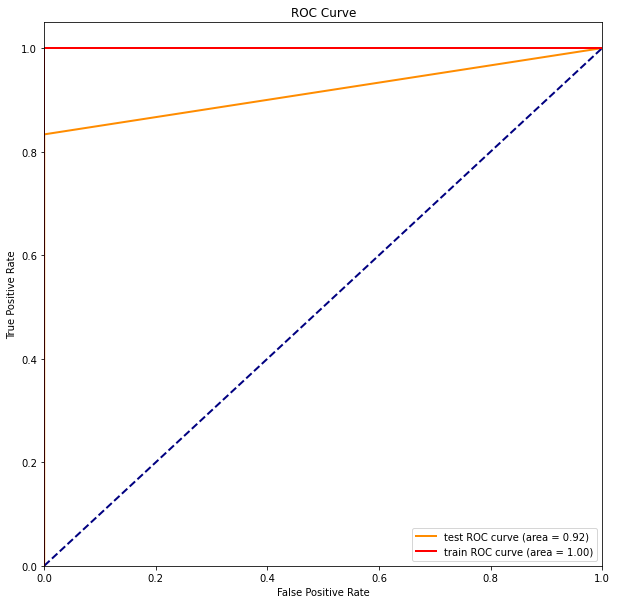


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9166666666666667
sensitivity: 1.0
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

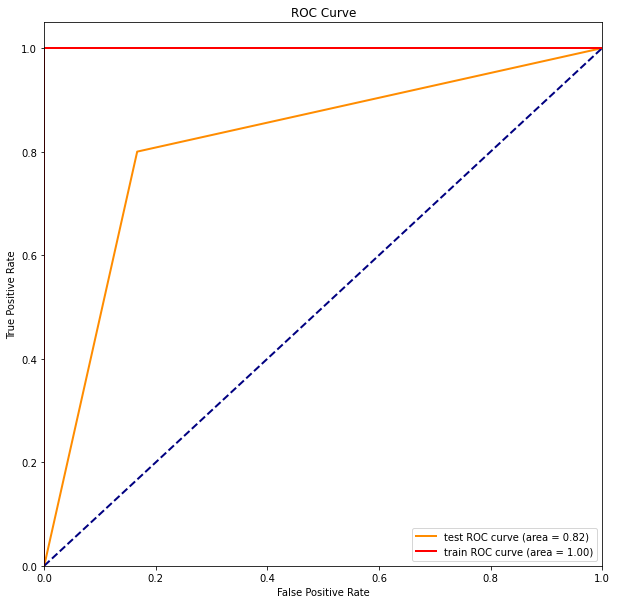


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8166666666666667
sensitivity: 0.8333333333333334
specificity: 0.8


<Figure size 432x288 with 0 Axes>

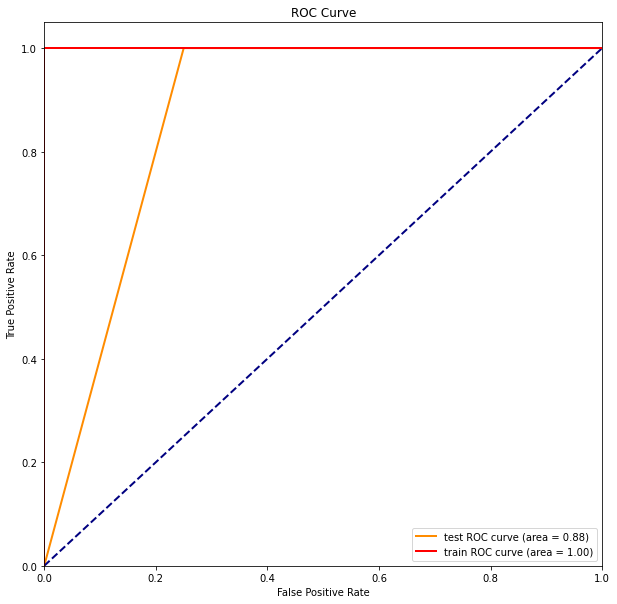


 训练集 1.0 测试集 0.9090909090909091
roc: 0.875
sensitivity: 0.75
specificity: 1.0


<Figure size 432x288 with 0 Axes>

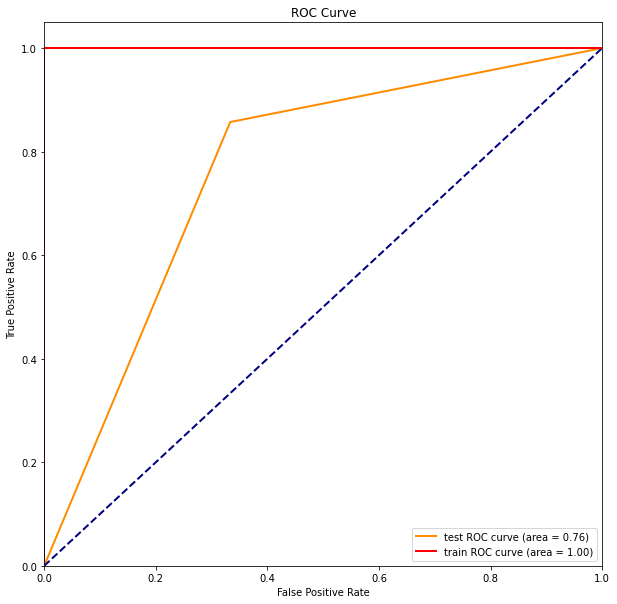


 训练集 1.0 测试集 0.8
roc: 0.7619047619047621
sensitivity: 0.6666666666666666
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

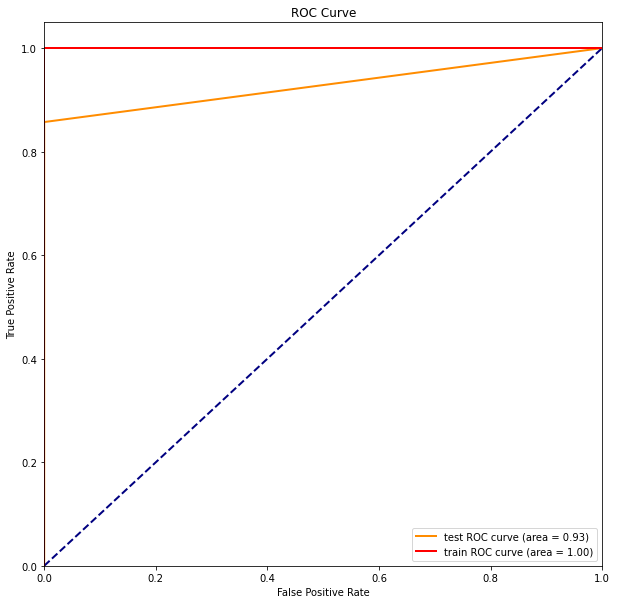


 训练集 1.0 测试集 0.9
roc: 0.9285714285714286
sensitivity: 1.0
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

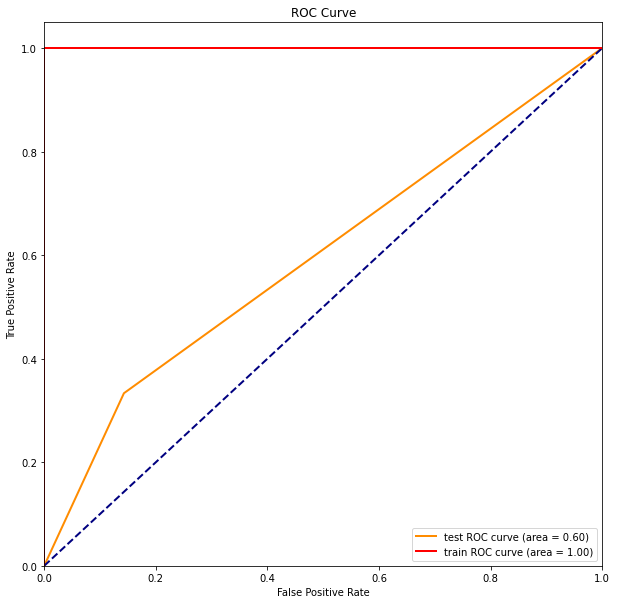


 训练集 1.0 测试集 0.7
roc: 0.5952380952380952
sensitivity: 0.8571428571428571
specificity: 0.3333333333333333


<Figure size 432x288 with 0 Axes>

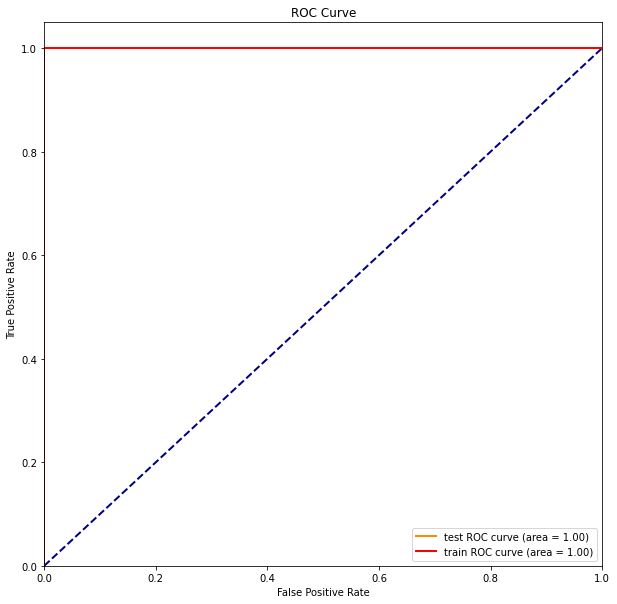


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

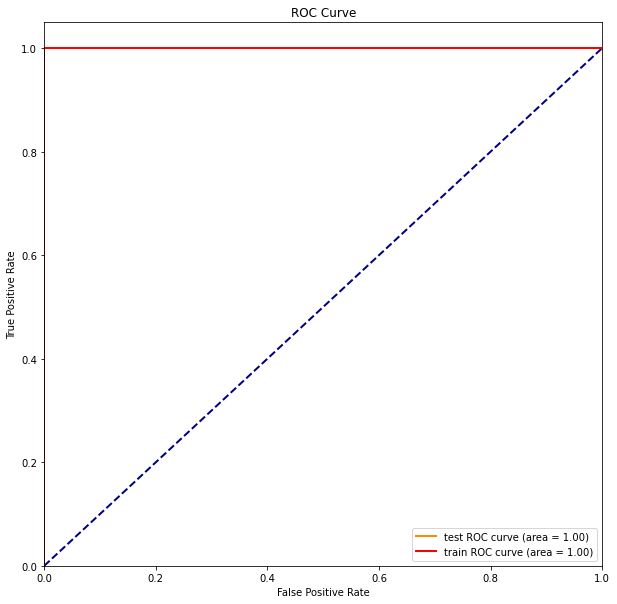


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

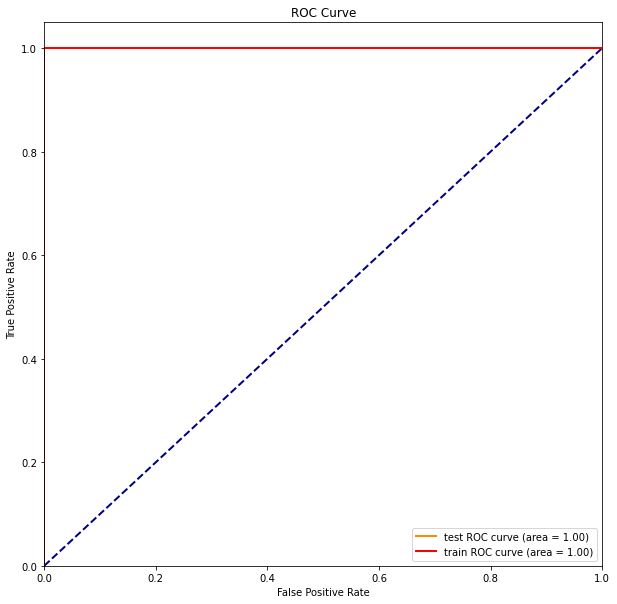


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

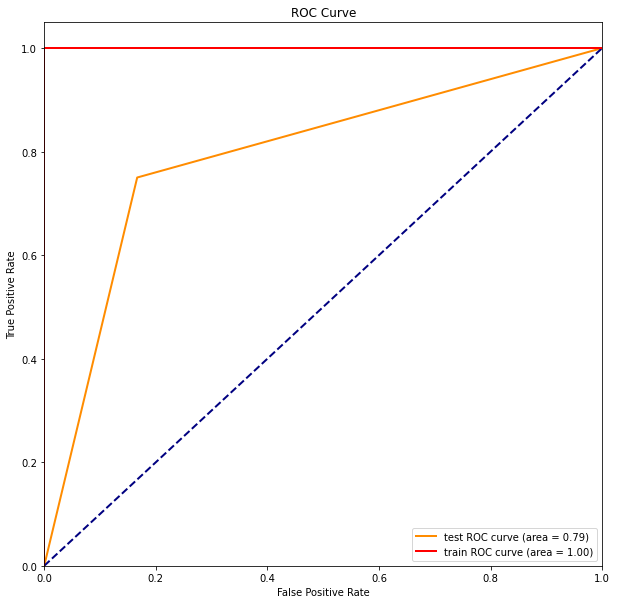


 训练集 1.0 测试集 0.8
roc: 0.7916666666666667
sensitivity: 0.8333333333333334
specificity: 0.75


<Figure size 432x288 with 0 Axes>

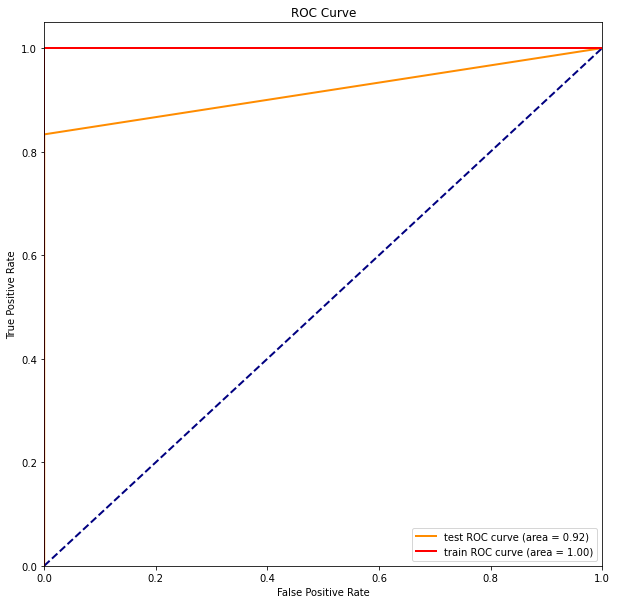


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9166666666666667
sensitivity: 1.0
specificity: 0.8333333333333334


<Figure size 432x288 with 0 Axes>

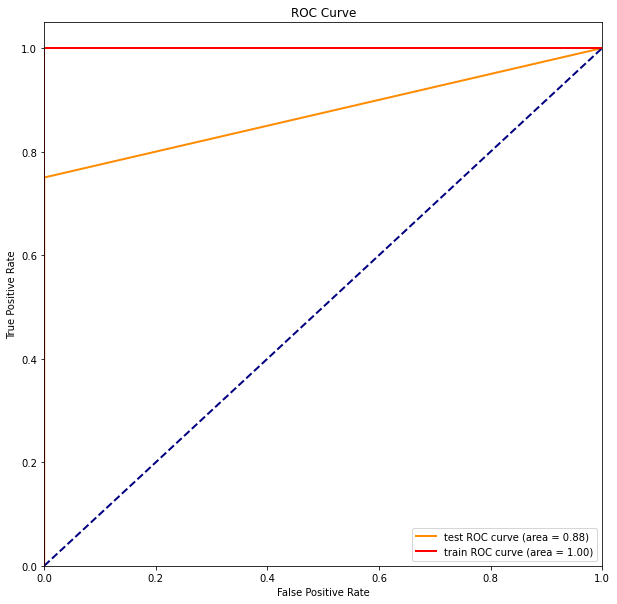


 训练集 1.0 测试集 0.8181818181818182
roc: 0.875
sensitivity: 1.0
specificity: 0.75


<Figure size 432x288 with 0 Axes>

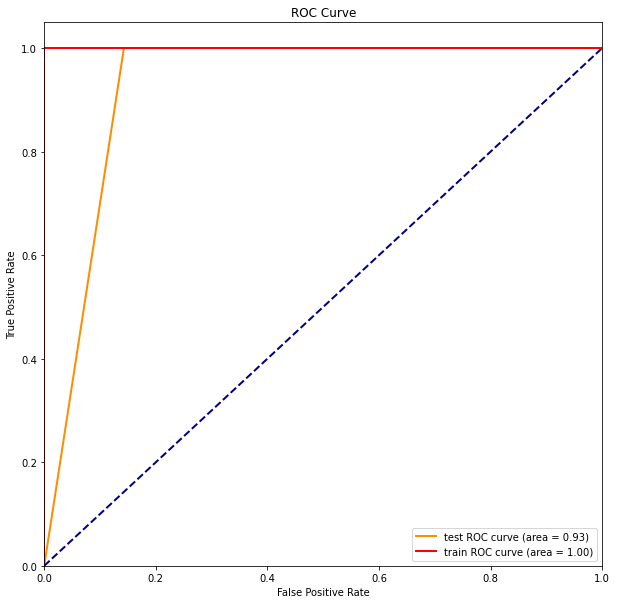


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9285714285714286
sensitivity: 0.8571428571428571
specificity: 1.0


<Figure size 432x288 with 0 Axes>

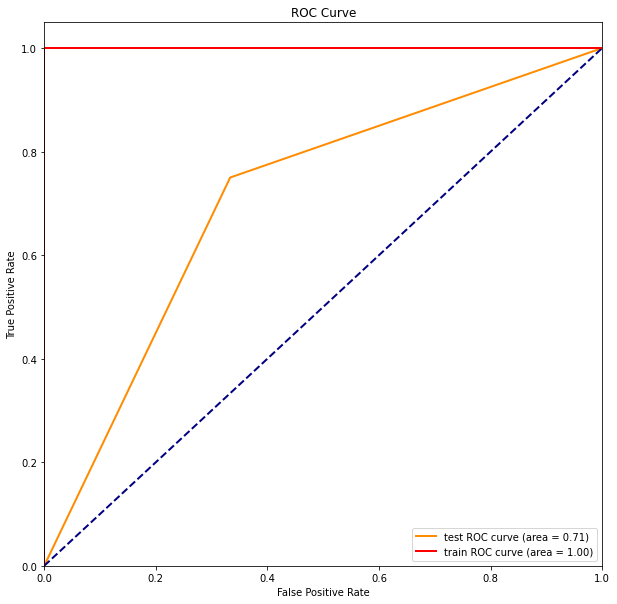


 训练集 1.0 测试集 0.7
roc: 0.7083333333333334
sensitivity: 0.6666666666666666
specificity: 0.75


<Figure size 432x288 with 0 Axes>

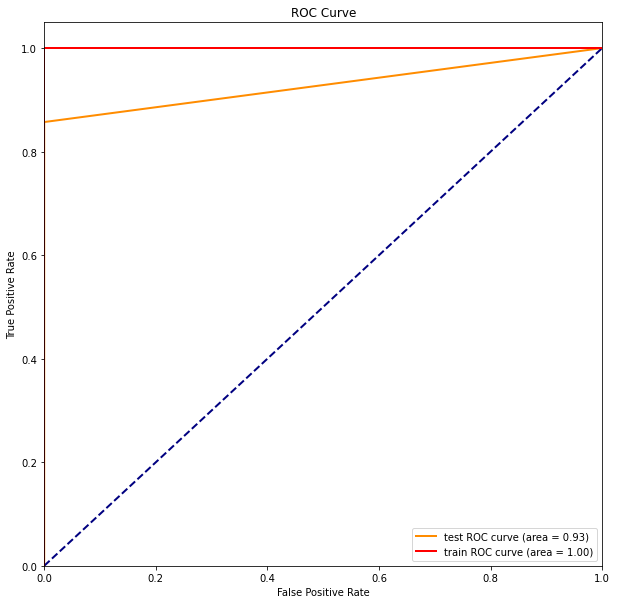


 训练集 1.0 测试集 0.9
roc: 0.9285714285714286
sensitivity: 1.0
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

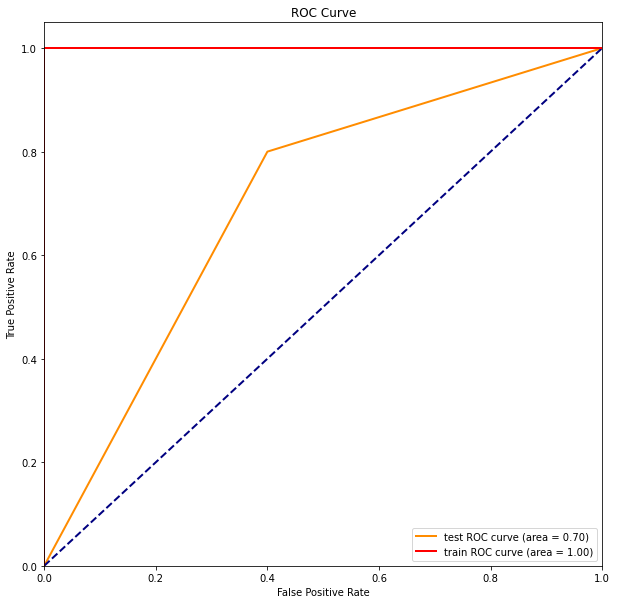


 训练集 1.0 测试集 0.7
roc: 0.7000000000000001
sensitivity: 0.6
specificity: 0.8


<Figure size 432x288 with 0 Axes>

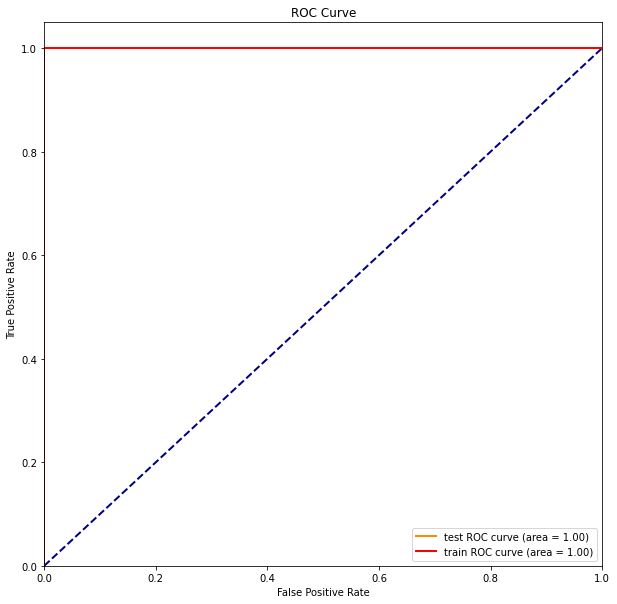


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

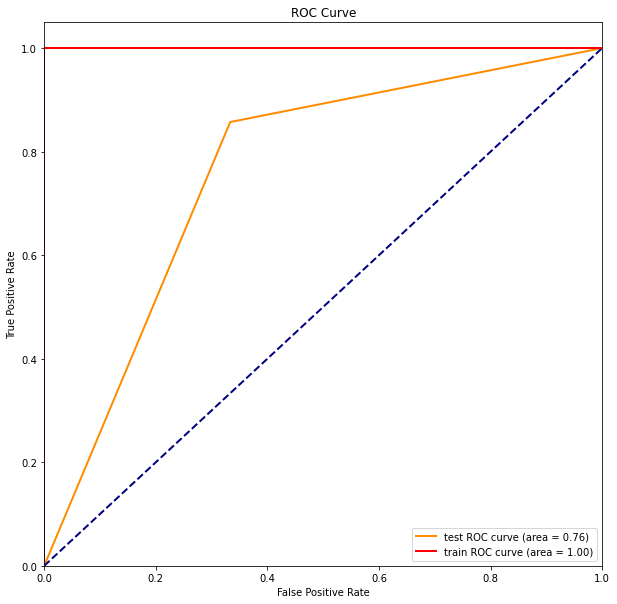


 训练集 1.0 测试集 0.8
roc: 0.7619047619047621
sensitivity: 0.6666666666666666
specificity: 0.8571428571428571


<Figure size 432x288 with 0 Axes>

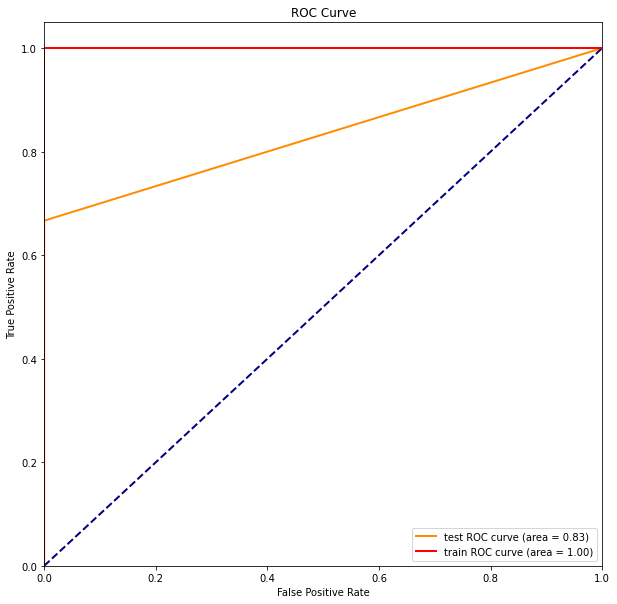


 训练集 1.0 测试集 0.9
roc: 0.8333333333333333
sensitivity: 1.0
specificity: 0.6666666666666666


<Figure size 432x288 with 0 Axes>

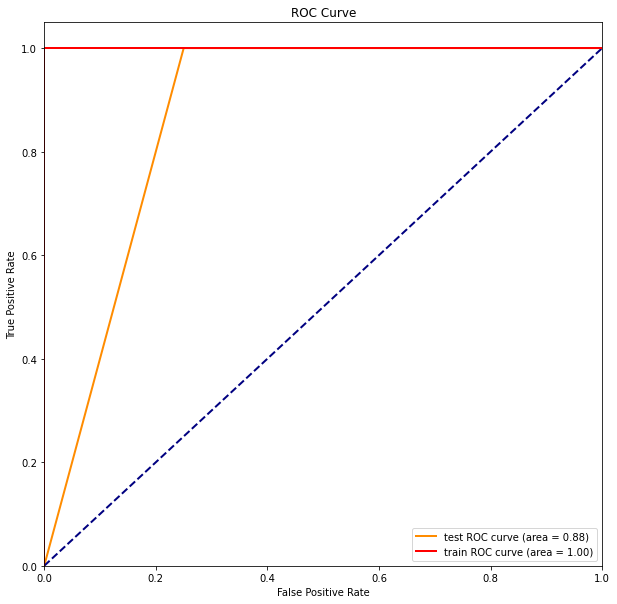


 训练集 1.0 测试集 0.8
roc: 0.875
sensitivity: 0.75
specificity: 1.0


<Figure size 432x288 with 0 Axes>

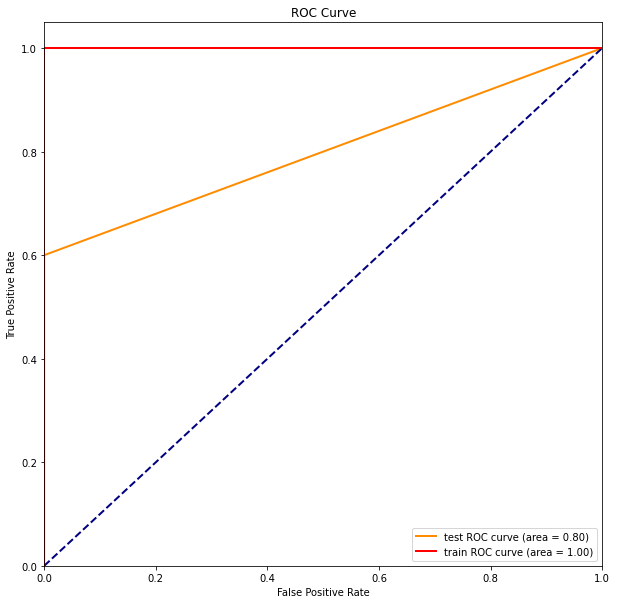


 训练集 1.0 测试集 0.8181818181818182
roc: 0.8
sensitivity: 1.0
specificity: 0.6


<Figure size 432x288 with 0 Axes>

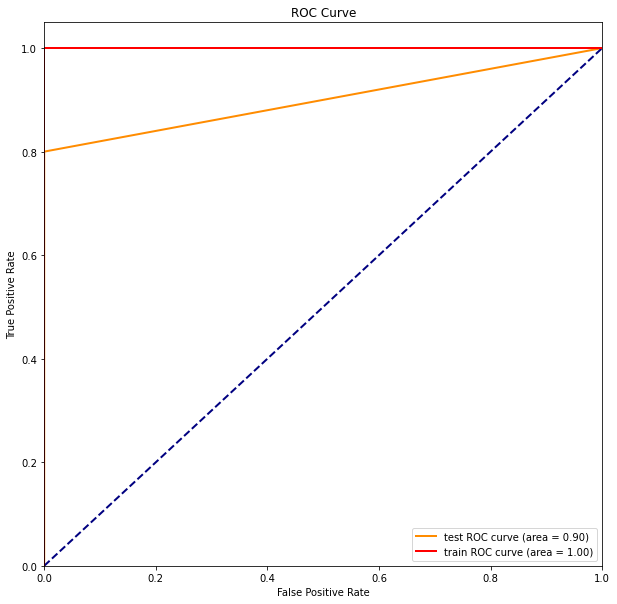


 训练集 1.0 测试集 0.9090909090909091
roc: 0.9
sensitivity: 1.0
specificity: 0.8


<Figure size 432x288 with 0 Axes>

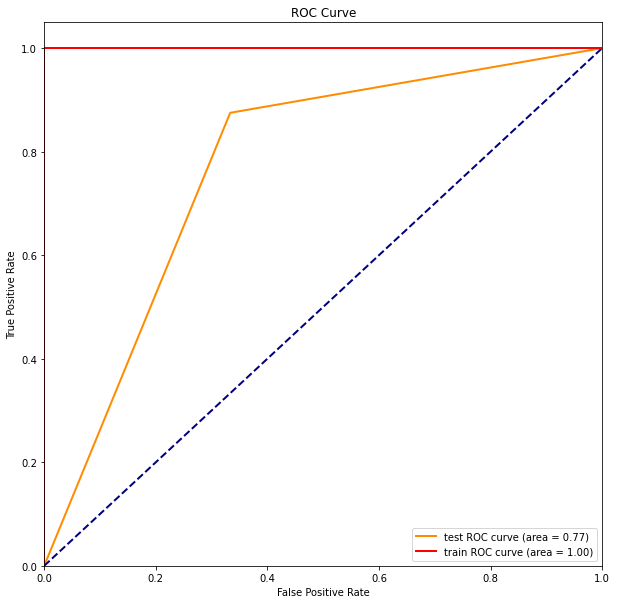


 训练集 1.0 测试集 0.8181818181818182
roc: 0.7708333333333335
sensitivity: 0.6666666666666666
specificity: 0.875


<Figure size 432x288 with 0 Axes>

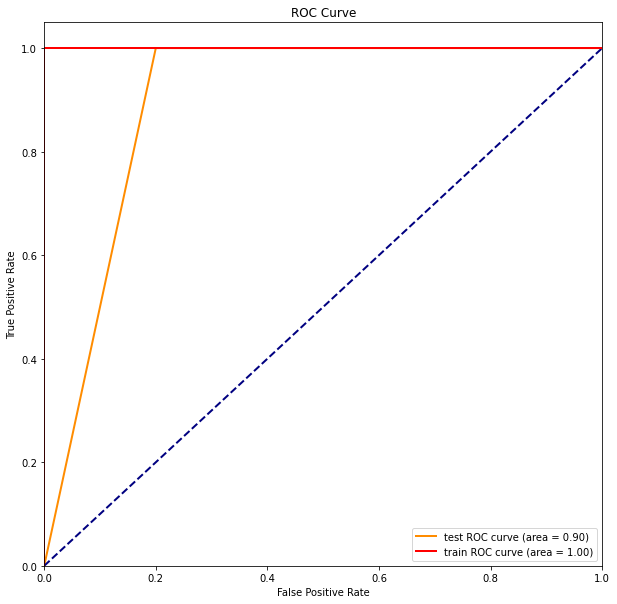


 训练集 1.0 测试集 0.9
roc: 0.9
sensitivity: 0.8
specificity: 1.0


<Figure size 432x288 with 0 Axes>

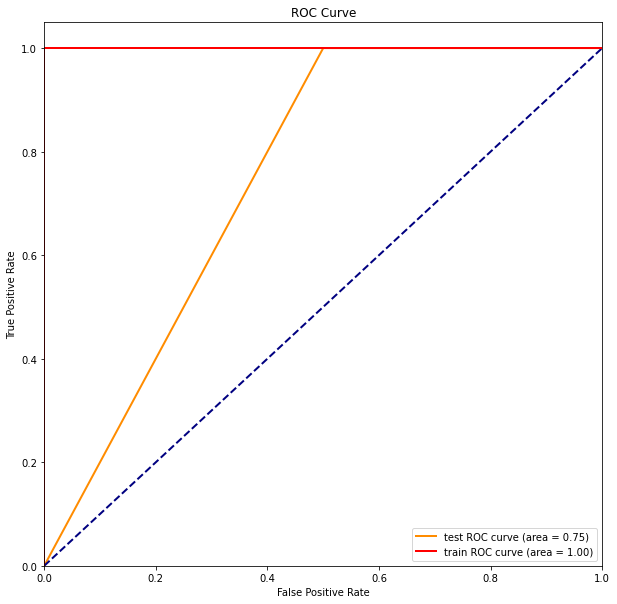


 训练集 1.0 测试集 0.9
roc: 0.75
sensitivity: 0.5
specificity: 1.0


<Figure size 432x288 with 0 Axes>

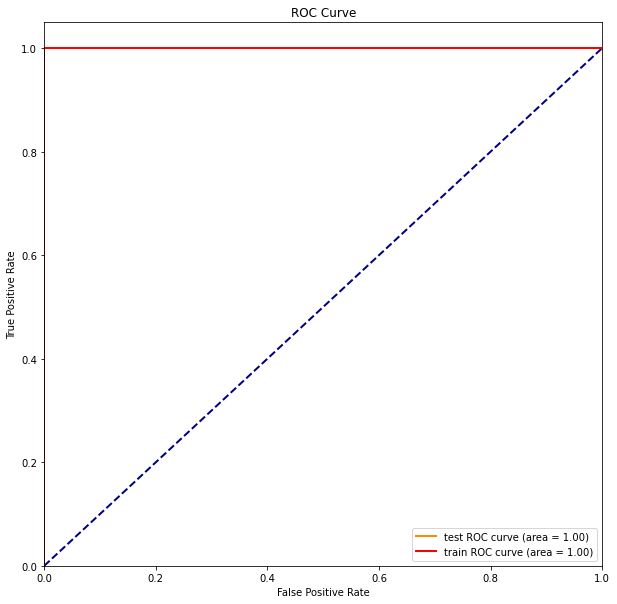


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

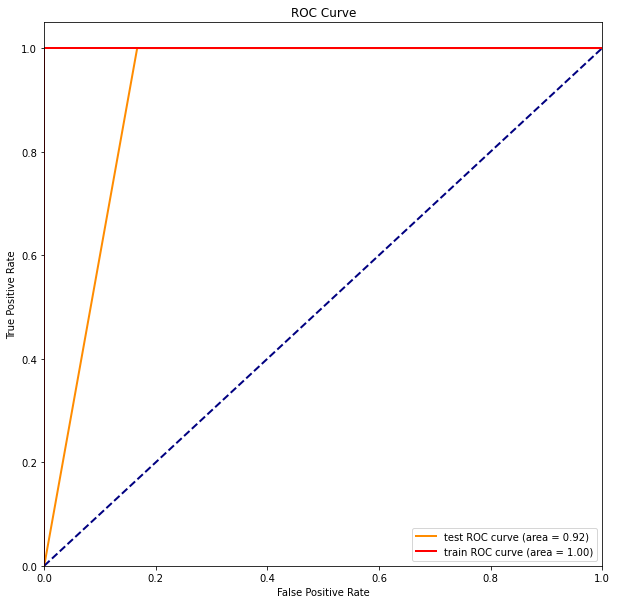


 训练集 1.0 测试集 0.9
roc: 0.9166666666666667
sensitivity: 0.8333333333333334
specificity: 1.0


<Figure size 432x288 with 0 Axes>

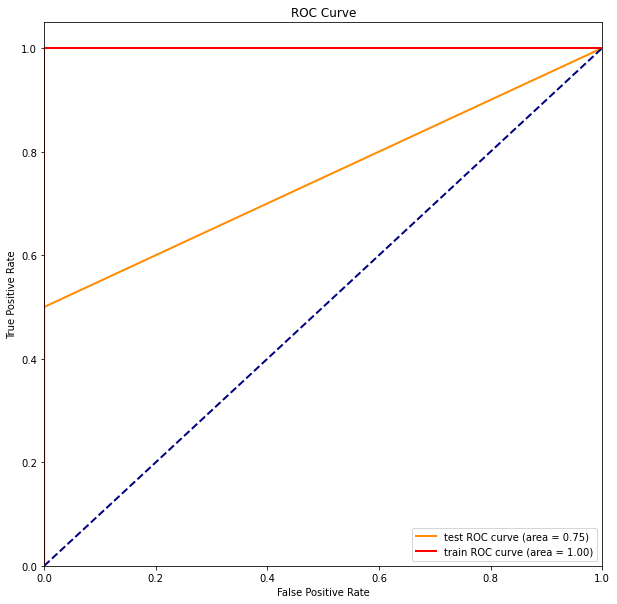


 训练集 1.0 测试集 0.8
roc: 0.75
sensitivity: 1.0
specificity: 0.5


<Figure size 432x288 with 0 Axes>

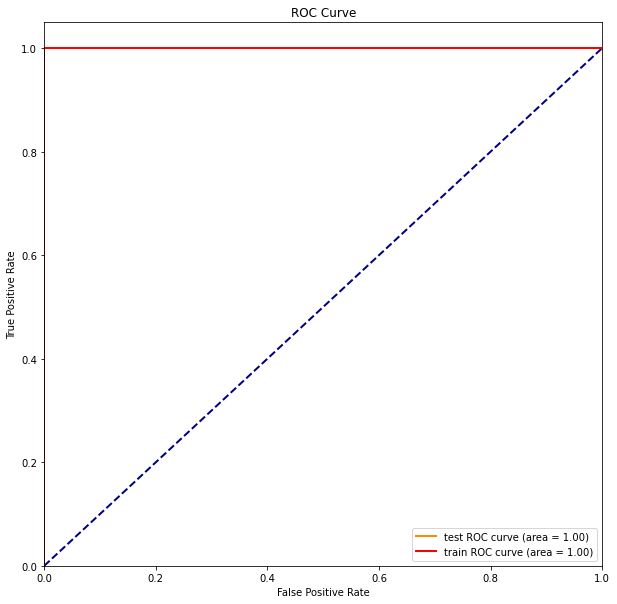


 训练集 1.0 测试集 1.0
roc: 1.0
sensitivity: 1.0
specificity: 1.0


<Figure size 432x288 with 0 Axes>

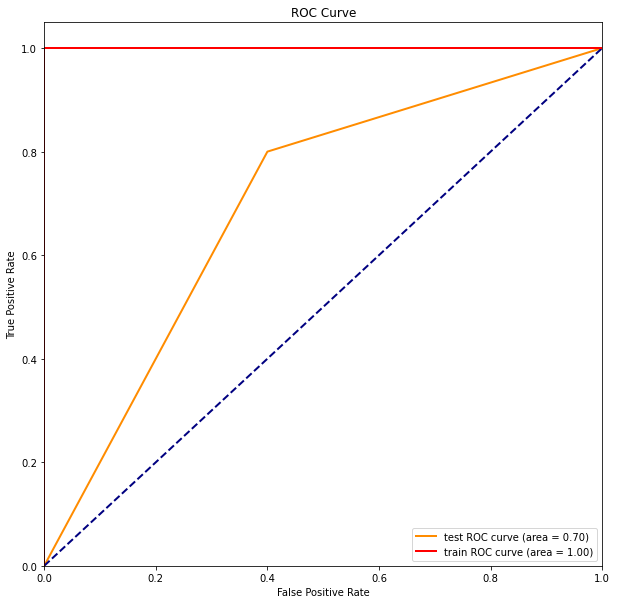


 训练集 1.0 测试集 0.7
roc: 0.7000000000000001
sensitivity: 0.6
specificity: 0.8
average test accuracy: 0.8767272727272729
average train accuracy: 1.0
average roc: 0.8774603174603176
average sensitivity: 0.882503968253968
average specificity: 0.8724166666666666


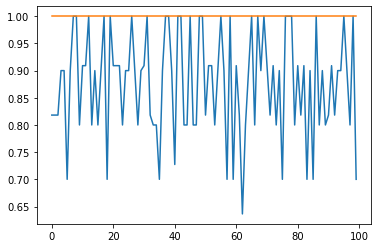

In [10]:
kfold_train_test(10)